In [1]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
from ncistd import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from ncistd.tensors import SparseCPTensor


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300


In [3]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# NOTE: align all the tensors to the same reference tensor

# import decompositions

In [4]:
# model selection

bootstraps = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rank = 30
lamb = 16.
replicates = ['A', 'B', 'C']

datapath = Path('../../data/4-fitting/syn/')


In [5]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
samplenames = {}
for boot in bootstraps:
    samplenames[boot] = {}
    for rep in replicates:
        ds = xr.open_dataset(datapath / 'bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(boot, rep, rep))
        samplenames[boot][rep] = ds.samplename.data

# collect
samplenames['common'] = reduce(
    np.intersect1d, 
    [samplenames[b][r] for b, r in list(itertools.product(bootstraps, replicates))]
)

tensor_ds = xr.open_dataset(datapath / 'bootstrap{}/dataset_bootstrap_{}.nc'.format(bootstraps[0], bootstraps[0]))

tensor_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6578, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040245 60040289
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...

In [6]:
# import fitted models

cps = {}
aligned_cps = {}

for boot in bootstraps:
    cps[boot] = {}
    aligned_cps[boot] = {}
    for rep in replicates:
        path_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
            boot, rep, rank, lamb
        )
        # store normalized cp tensor to cps
        cps[boot][rep] = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
        # pull out aligned cps
        idx = np.where(np.isin(samplenames[boot][rep], samplenames['common']))[0]
        aligned_cps[boot][rep] = subset_cp_tensor(cps[boot][rep], {2: idx})
        # permute components to line up
        if rep == 'A':
            # arrange components in descending order of explained variance
            aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
                aligned_cps[boot][rep], 
                consider_weights=False
            )
        else:
            # permute factors of B & C cp tensors to best match A
            aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
                aligned_cps[boot][rep], 
                reference_cp_tensor=aligned_cps[boot]['A'], 
                consider_weights=False
            )

aligned_cps[0]['A']


(weights, factors) : rank-30 CPTensor of shape (6578, 6, 55)

# compare each component against all other cp tensors in the set

In [7]:
# find best reference cp in the set

results = []
for ref_boot, ref_rep in list(itertools.product(bootstraps, replicates)):
    reference_cp = aligned_cps[ref_boot][ref_rep]
    for comp_boot, comp_rep in list(itertools.product(bootstraps, replicates)):
        # no point in comparing to self
        if ref_boot == comp_boot and ref_rep == comp_rep:
            continue
        comparison_cp = aligned_cps[comp_boot][comp_rep]
        fms = factor_match_score(
            reference_cp, 
            comparison_cp, 
            consider_weights=False
        )
        results.append({
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'fms': fms, 
        })
        
fms_df = pd.DataFrame(results)
summary_fms_df = fms_df.groupby(
    ['reference_bootstrap', 'reference_replicate'])['fms'].mean().reset_index()
summary_fms_df = summary_fms_df.sort_values('fms', ascending=False).reset_index(drop=True)
summary_fms_df


,reference_bootstrap,reference_replicate,fms
0,0,A,0.658051
1,8,B,0.649429
2,7,A,0.647292
3,5,B,0.646778
4,2,A,0.638398
5,9,A,0.637443
6,4,A,0.636202
7,1,B,0.635157
8,2,C,0.631984
9,2,B,0.631218


In [13]:
# function to compare each component of an input SparseCPTensor to each of a set of CPTensors
# and obtain the best match FMS

# take the model with the top mean FMS as the main reference
ref_boot = 0
ref_rep = 'A'
reference_scp = SparseCPTensor(aligned_cps[ref_boot][ref_rep])

results = []
for i, component in enumerate(reference_scp.get_components()):
    for comp_boot, comp_rep in list(itertools.product(bootstraps, replicates)):
        # no point in comparing to self
        if ref_boot == comp_boot and ref_rep == comp_rep:
            continue
        # re-align comparison cp to the reference cp
        comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_cps[comp_boot][comp_rep], 
            reference_cp_tensor=reference_scp, 
            consider_weights=False
        )                
        # greedy approach - find the single best component match in each bootstrapped model
        fms, perm = factor_match_score(
            component, 
            comparison_cp, 
            return_permutation=True, 
            consider_weights=False,
            allow_smaller_rank=True
        )
        results.append({
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'reference_component': i, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'best_match_component': perm[0], 
            'fms': fms 
        })
        
component_df = pd.DataFrame(results)
summary_component_df = component_df.groupby(['reference_bootstrap', 'reference_replicate', 
                      'reference_component', 'best_match_component']).agg(
    n_best_components=('best_match_component', 'count'), 
    mean_fms=('fms', 'mean')
)
summary_component_df = summary_component_df.sort_values(['n_best_components', 'mean_fms'], ascending=False)

summary_component_df.head(50)


n_best_components  \
reference_bootstrap reference_replicate reference_component best_match_component                      
0                   A                   5                   5                                    29   
                                        4                   4                                    29   
                                        3                   3                                    29   
                                        9                   9                                    29   
                                        14                  14                                   29   
                                        12                  12                                   29   
                                        2                   2                                    29   
                                        6                   6                                    29   
                                        21                  21                                   29   
                                        7                   7                                    28   
                                        8                   8                                    28   
                                        18                  18                                   28   
                                        23                  23                                   27   
                                        10                  10                                   27   
                                        13                  13                                   26   
                                        27                  27                                   26   
                                        1                   1                                    25   
                                        19                  19                                   25   
                                        16                  16                                   25   
                                        17                  17                                   23   
                                        11                  11                                   22   
                                        25                  25                                   22   
                                        26                  26                                   21   
                                        22                  22                                   21   
                                        20                  20                                   21   
                                        29                  27                                   17   
                                        28                  28                                   15   
                                        0                   0                                    14   
                                                            10                                   13   
                                        24                  26                                   12   
                                        15                  8                                    12   
                                        24                  23                                   11   
                                        15                  15                                    8   
                                        28                  27                                    8   
                                        22                  9                                     8   
                                        20                  1                                     8   
                                        15                  17                                    8   
                                        11                  8    

# compare against models with fewer components

In [65]:
# model selection

subrank = 25

subrank_cps = {}
aligned_subrank_cps = {}

for boot in bootstraps:
    subrank_cps[boot] = {}
    aligned_subrank_cps[boot] = {}
    for rep in replicates:
        path_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
            boot, rep, subrank, lamb
        )
        # store normalized cp tensor to cps
        subrank_cps[boot][rep] = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
        # pull out aligned cps
        idx = np.where(np.isin(samplenames[boot][rep], samplenames['common']))[0]
        aligned_subrank_cps[boot][rep] = subset_cp_tensor(subrank_cps[boot][rep], {2: idx})
        # permute components to line up
        if rep == 'A':
            # arrange components in descending order of explained variance
            aligned_subrank_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
                aligned_subrank_cps[boot][rep], 
                consider_weights=False
            )
        else:
            # permute factors of B & C cp tensors to best match A
            aligned_subrank_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
                aligned_subrank_cps[boot][rep], 
                reference_cp_tensor=aligned_subrank_cps[boot]['A'], 
                consider_weights=False
            )

aligned_subrank_cps[0]['A']


(weights, factors) : rank-25 CPTensor of shape (6578, 6, 55)

In [66]:
# find best full-rank reference cp

results = []
for ref_boot, ref_rep in list(itertools.product(bootstraps, replicates)):
    reference_cp = aligned_cps[ref_boot][ref_rep]
    for comp_boot, comp_rep in list(itertools.product(bootstraps, replicates)):
        comparison_cp = aligned_subrank_cps[comp_boot][comp_rep]
        fms = factor_match_score(
            reference_cp, 
            comparison_cp, 
            consider_weights=False
        )
        results.append({
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'fms': fms, 
        })
        
fms_df = pd.DataFrame(results)
summary_fms_df = fms_df.groupby(
    ['reference_bootstrap', 'reference_replicate'])['fms'].mean().reset_index()
summary_fms_df = summary_fms_df.sort_values('fms', ascending=False).reset_index(drop=True)
summary_fms_df


,reference_bootstrap,reference_replicate,fms
0,0,A,0.725240
1,5,B,0.712216
2,7,A,0.711874
3,8,B,0.709507
4,4,A,0.705083
5,2,A,0.702706
6,2,C,0.700138
7,1,A,0.697500
8,1,B,0.695307
9,2,B,0.692868


In [68]:
# compare each component of an input SparseCPTensor to each of a set of CPTensors
# and obtain the best match FMS

# take the model with the top mean FMS as the main reference
ref_boot = summary_fms_df.loc[0, 'reference_bootstrap']
ref_rep = summary_fms_df.loc[0, 'reference_replicate']
reference_scp = SparseCPTensor(aligned_cps[ref_boot][ref_rep])

results = []

for comp_boot, comp_rep in list(itertools.product(bootstraps, replicates)):
    comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_subrank_cps[comp_boot][comp_rep], 
            reference_cp_tensor=reference_scp, 
            allow_smaller_rank=True, 
            consider_weights=False
        )   
    comparison_cp = SparseCPTensor(comparison_cp)
    for i, component in enumerate(comparison_cp.get_components()):
        if np.all(np.isnan(component.factors[0])):
            continue
        # greedy approach - find the single best component match in each bootstrapped model
        fms, perm = factor_match_score(
            component, 
            reference_scp, 
            return_permutation=True, 
            consider_weights=False,
            allow_smaller_rank=True
        )
        results.append({
            'reference_bootstrap': ref_boot, 
            'reference_replicate': ref_rep, 
            'reference_component': perm[0], 
            'comparison_rank': subrank, 
            'comparison_bootstrap': comp_boot, 
            'comparison_replicate': comp_rep, 
            'comparison_component': i, 
            'fms': fms 
        })
        
component_df = pd.DataFrame(results)
summary_component_df = component_df.groupby(['comparison_rank', 'comparison_component', 
                      'reference_component']).agg(
    match_count=('fms', 'count'), 
    mean_fms=('fms', 'mean')
)
# summary_component_df = summary_component_df.sort_values('match_count', ascending=False)

summary_component_df.tail(50)

match_count  \
comparison_rank comparison_component reference_component                
25              15                   9                              1   
                                     10                             1   
                                     13                             1   
                                     14                             1   
                                     15                             6   
                                     19                             1   
                                     21                             1   
                16                   0                              3   
                                     6                              1   
                                     8                              1   
                                     16                            13   
                17                   0                              2   
                                     6                              1   
                                     17                            19   
                                     21                             1   
                18                   18                            22   
                19                   19                            21   
                20                   1                              5   
                                     14                             3   
                                     20                            16   
                21                   3                              1   
                                     12                             1   
                                     21                            28   
                22                   6                              4   
                                     8                              1   
                                     9                              2   
                                     14                             1   
                                     21                             1   
                                     22                            17   
                23                   23                            28   
                24                   0                              1   
                                     7                              1   
                                     13                             3   
                                     23                             3   
                                     24                             6   
                25                   1                              1   
                                     14                             1   
                                     25                            19   
                26                   23                             1   
                                     26                             8   
                27                   27                            28   
                28                   3                              2   
                                     7                              1   
                                     12                             1   
                                     21                             5   
                                     28                            13   
                29                   3                              2   
                                     22                             1   
                                     27                             1   
                                     29                             1   

                                                          mean_fms  
comparison_rank comparison_component reference_component            
25              15                   9                    0.521631  
                                     10               

# ecotype figure
Weights by ecotype by split

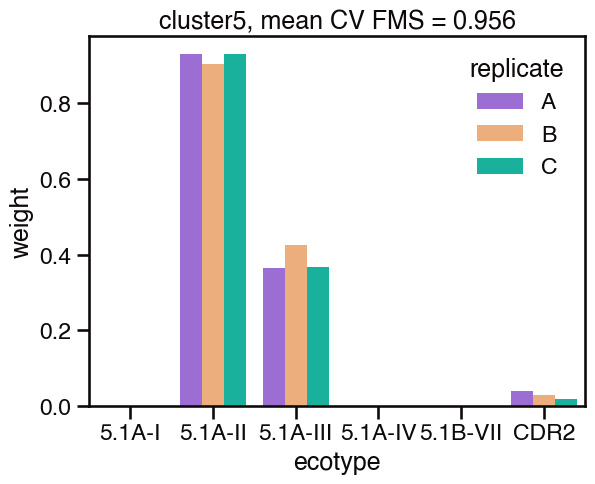

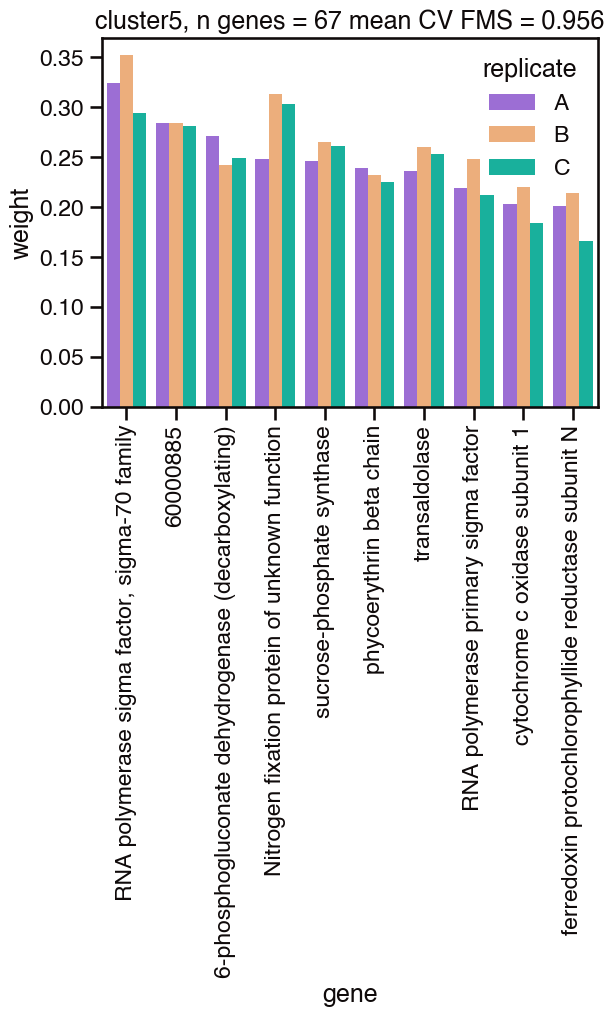

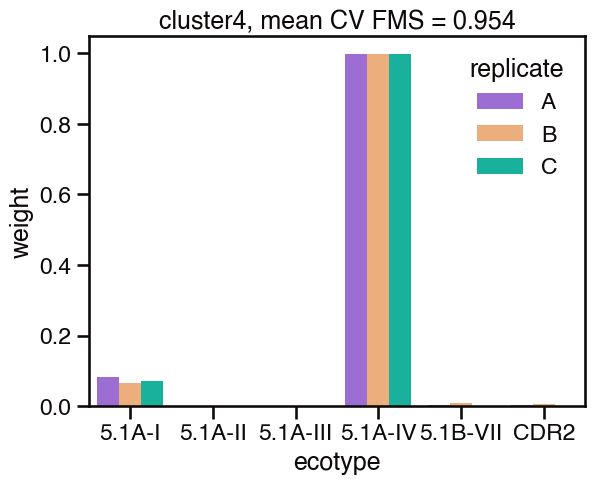

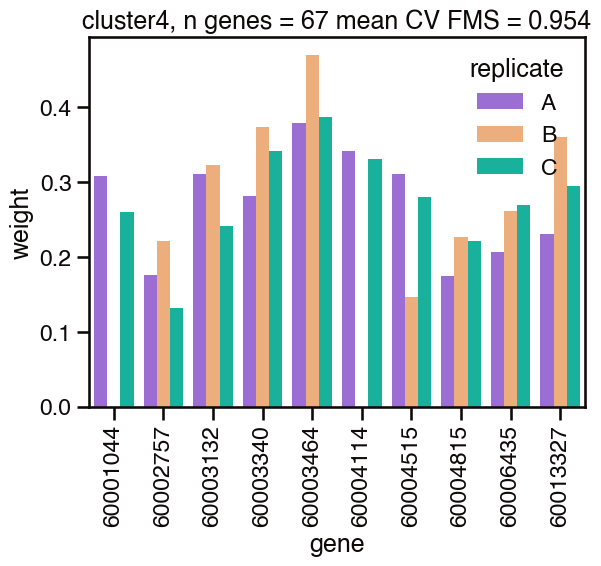

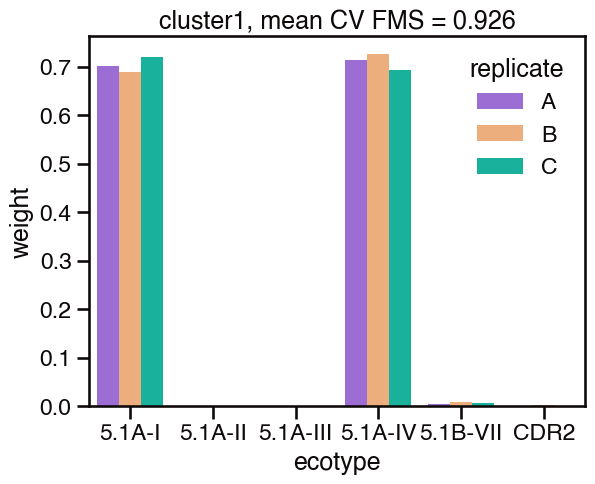

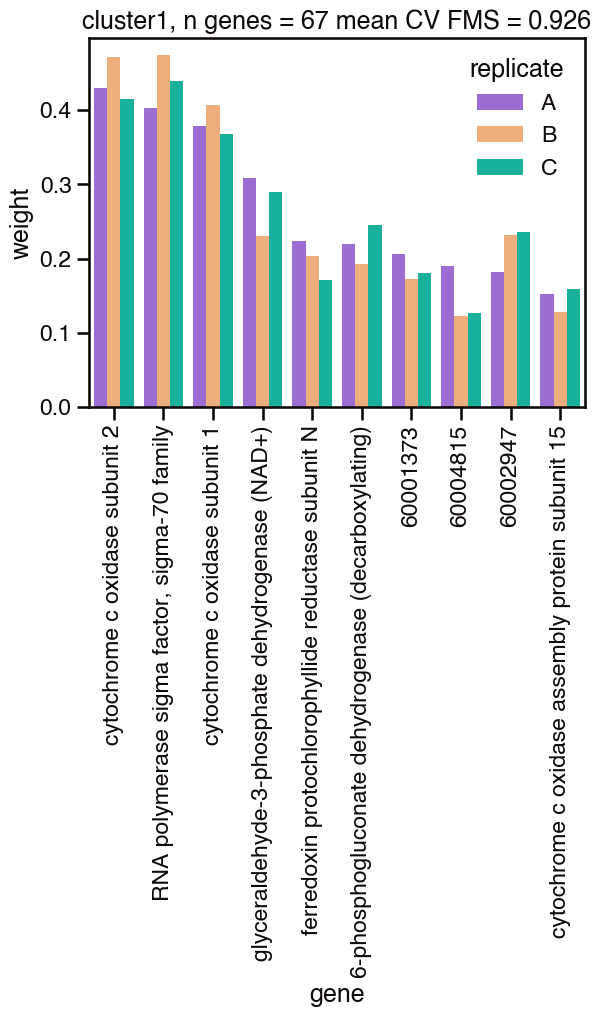

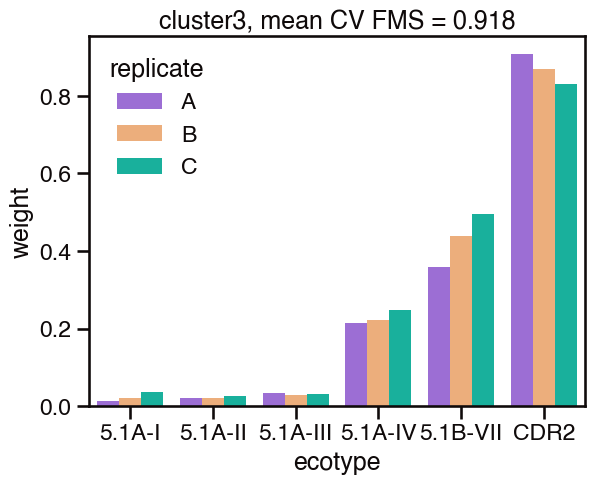

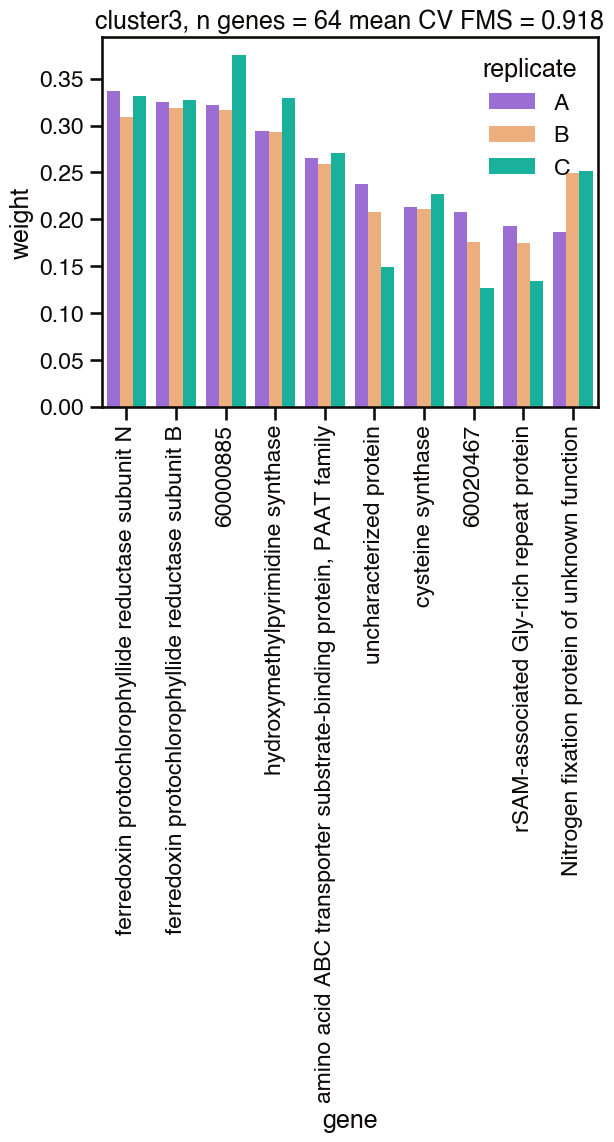

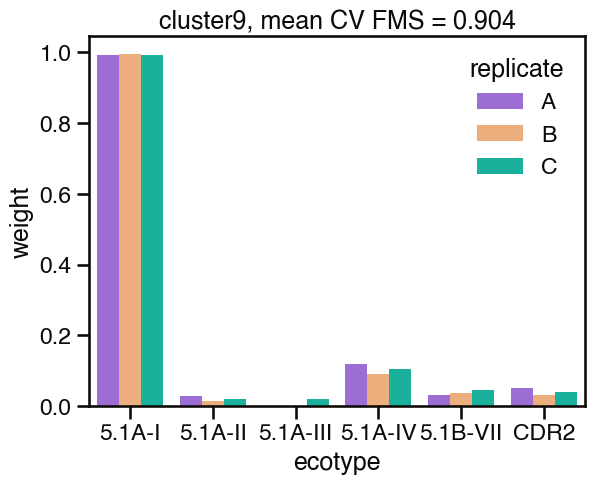

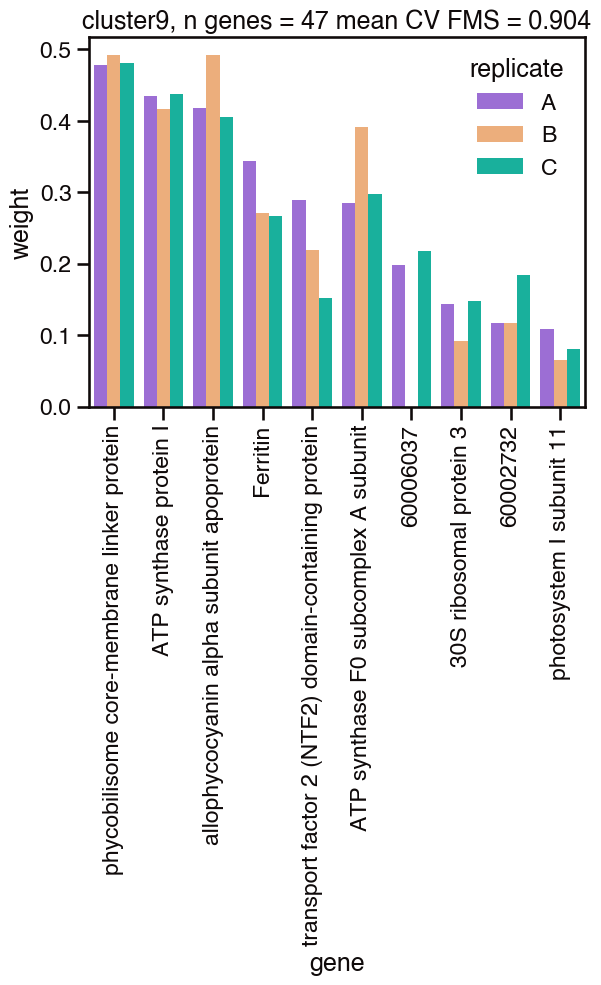

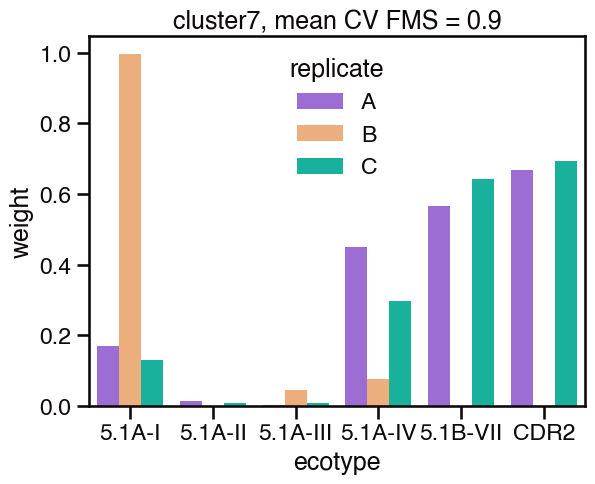

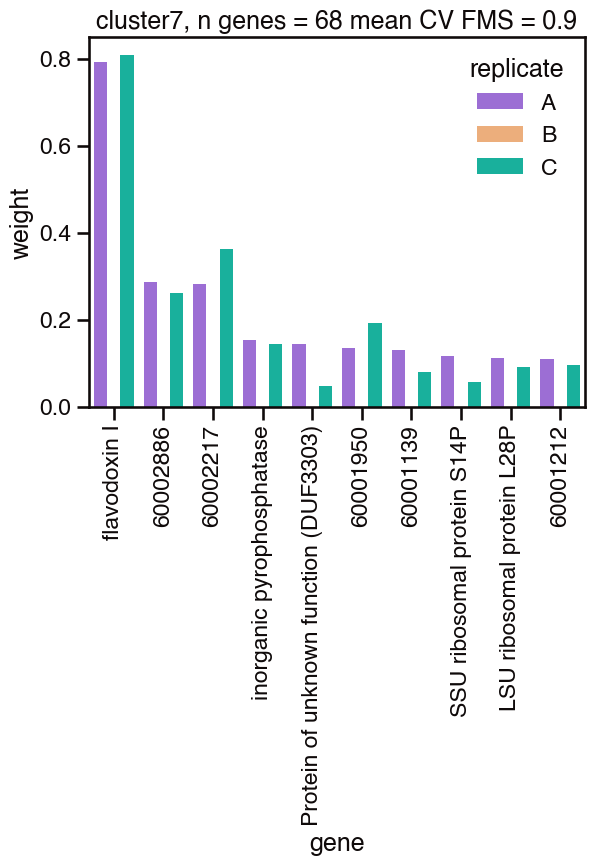

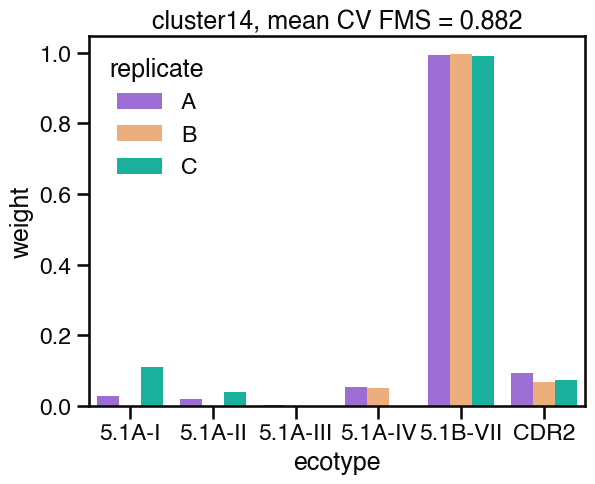

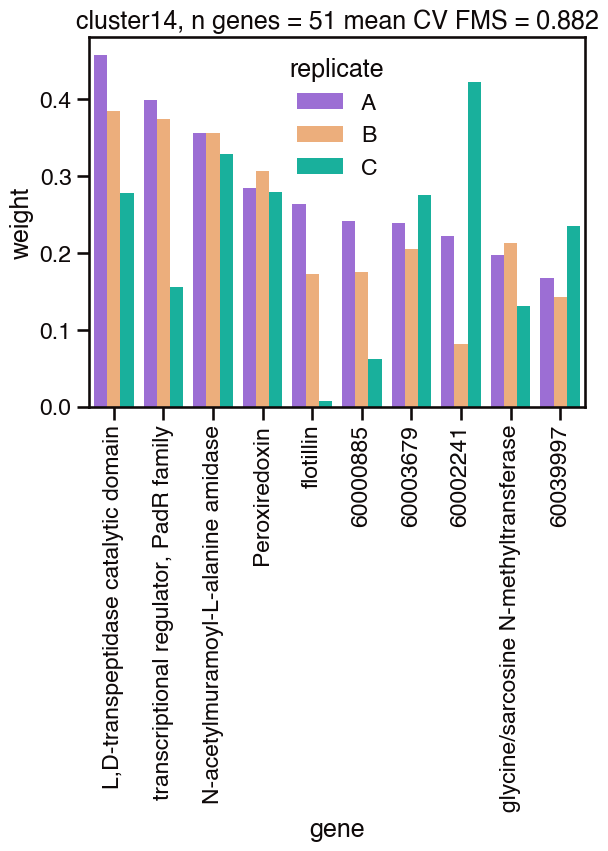

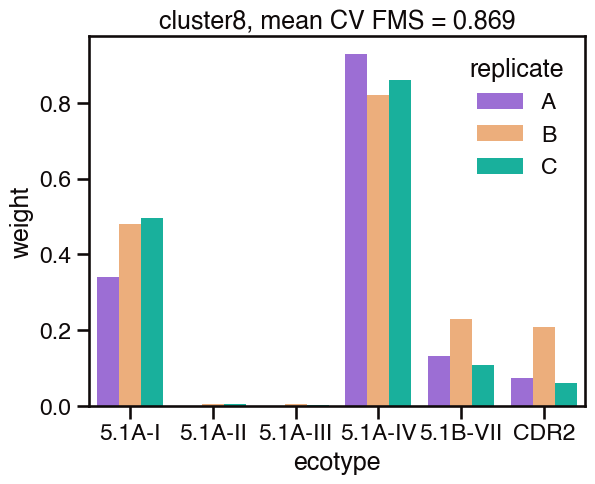

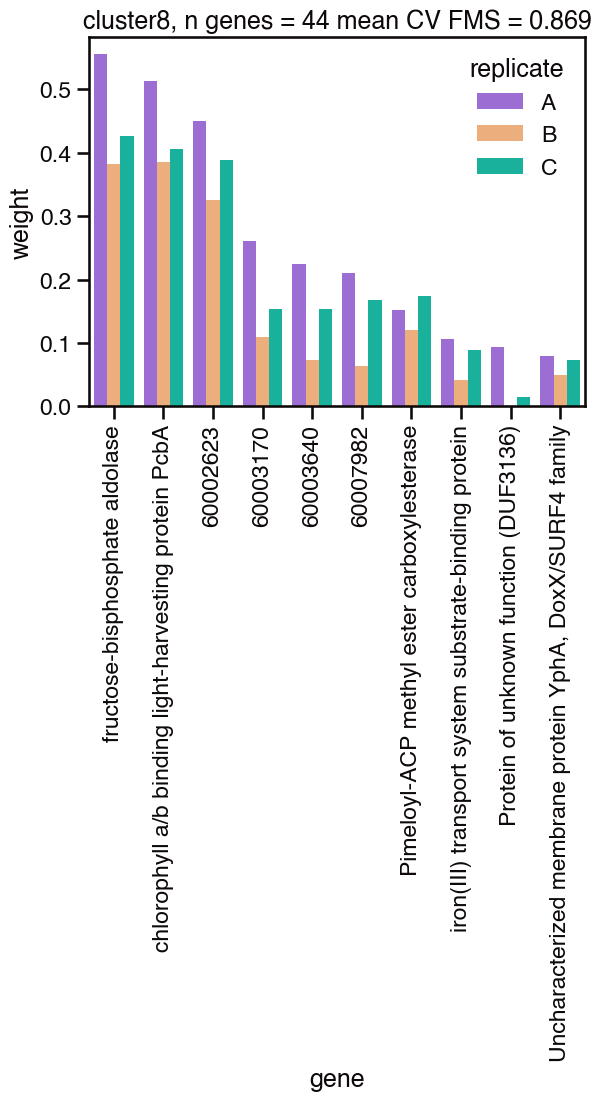

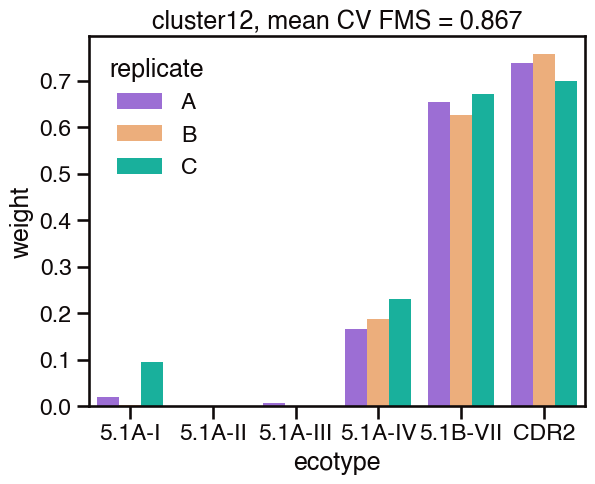

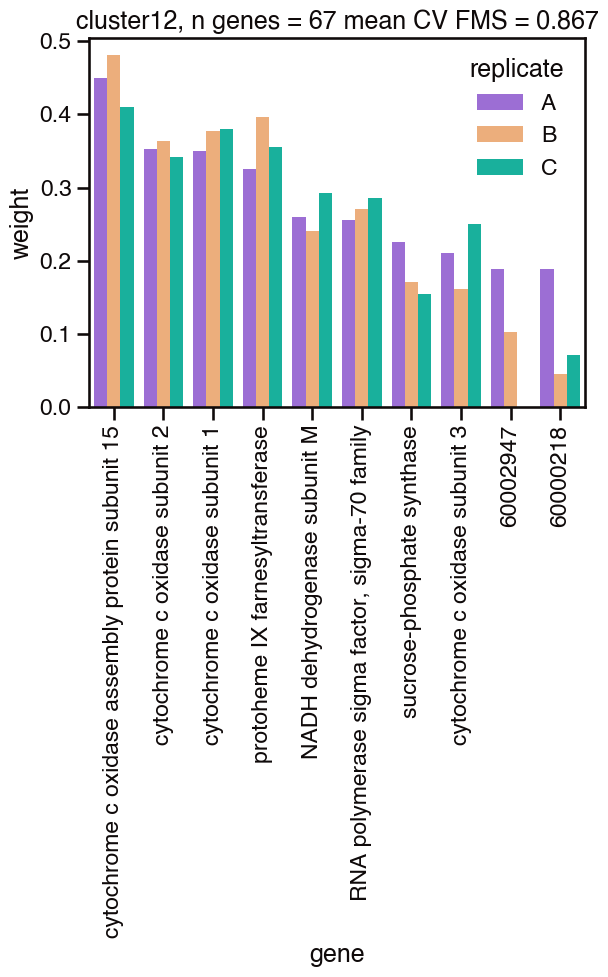

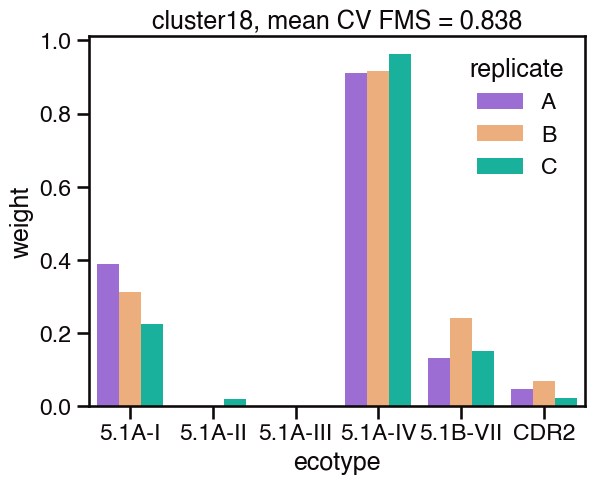

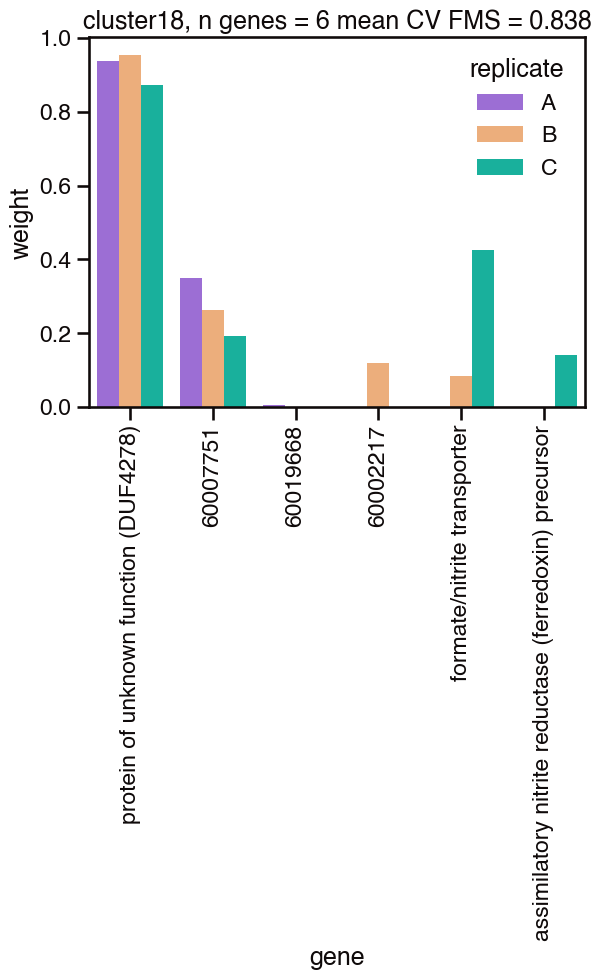

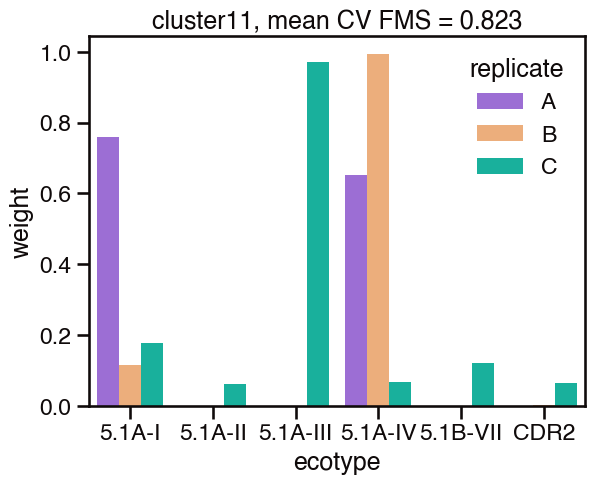

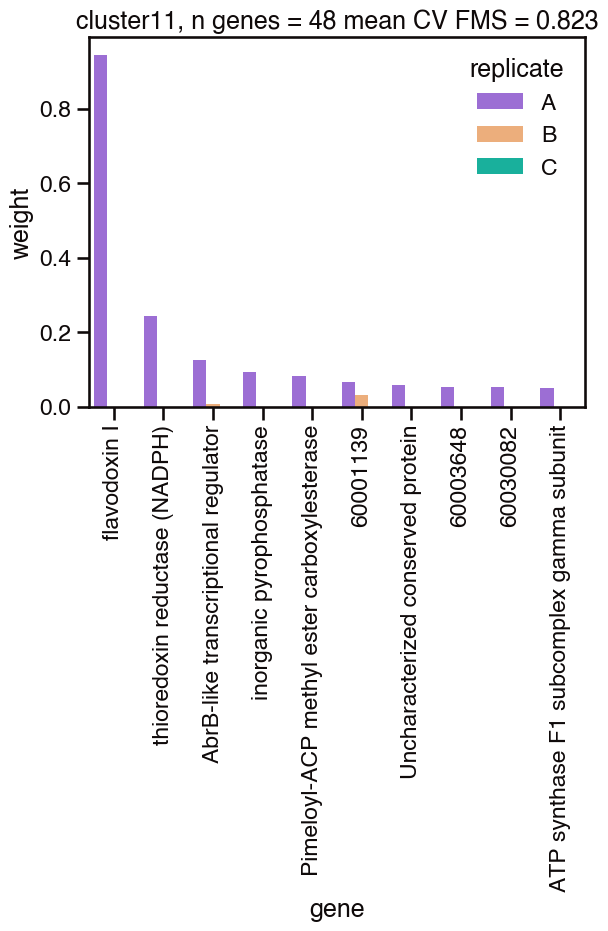

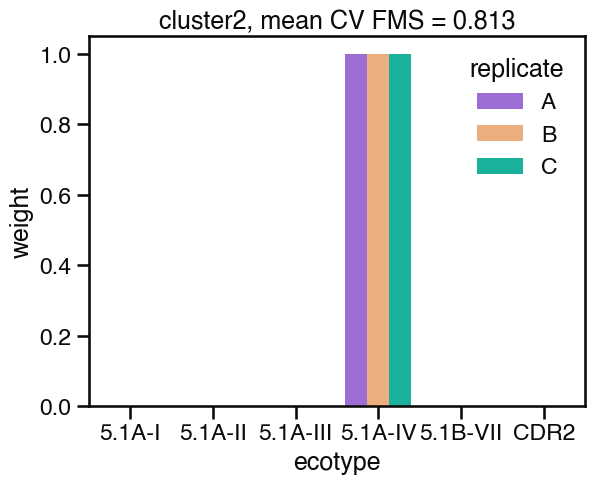

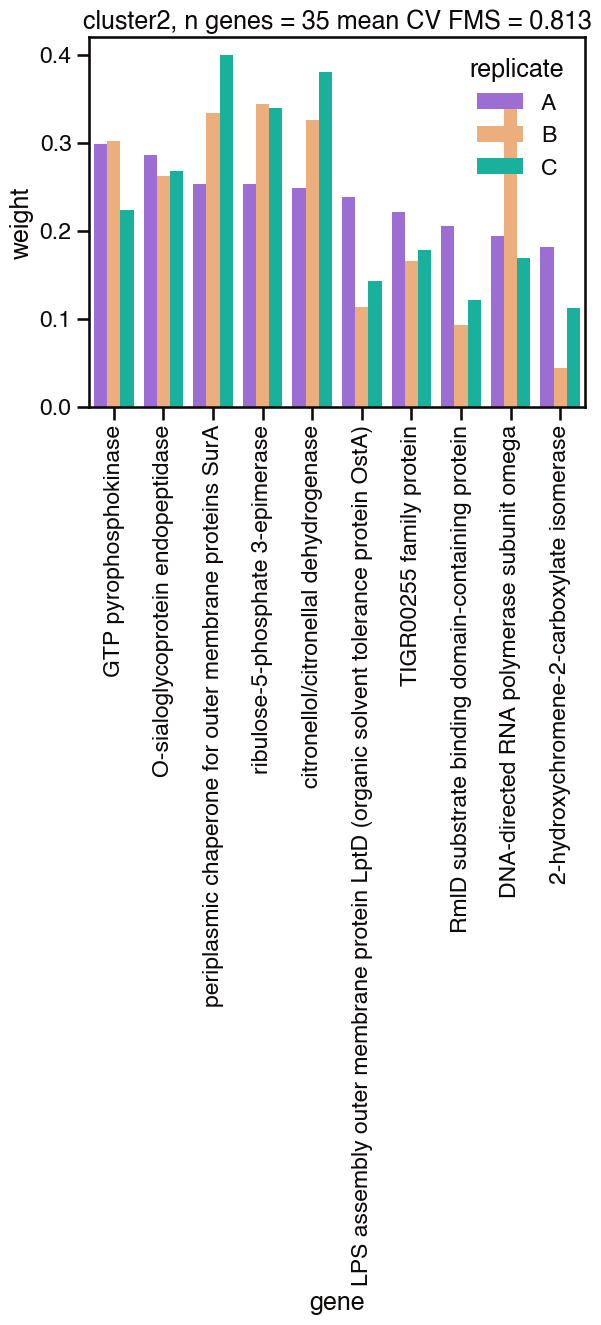

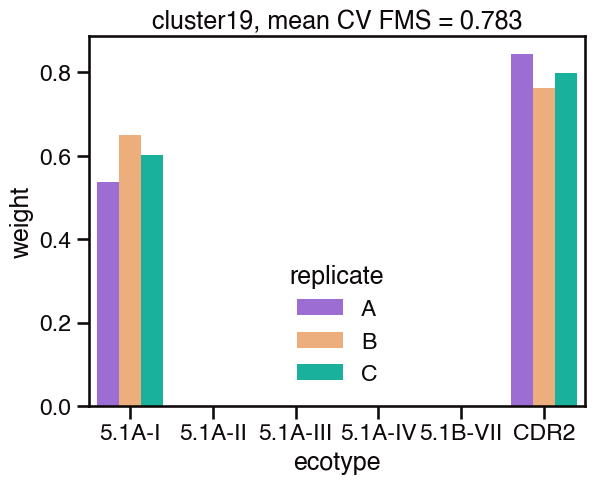

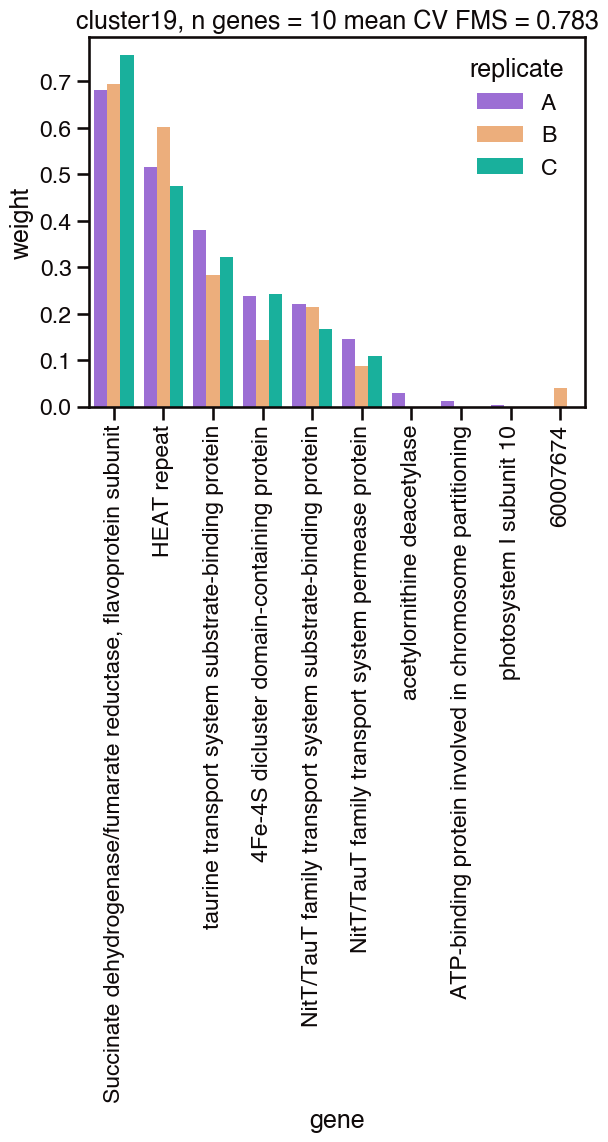

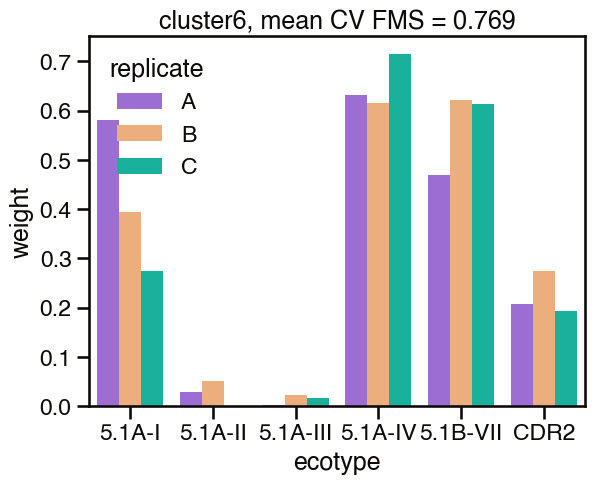

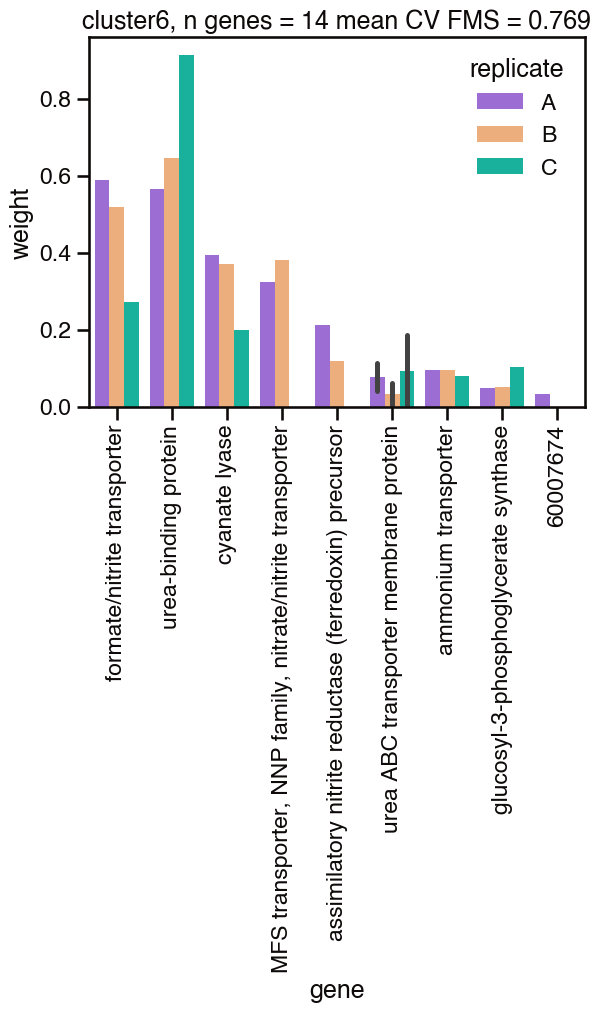

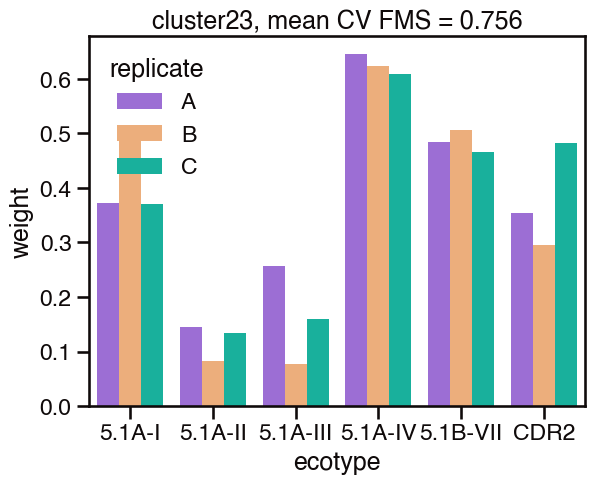

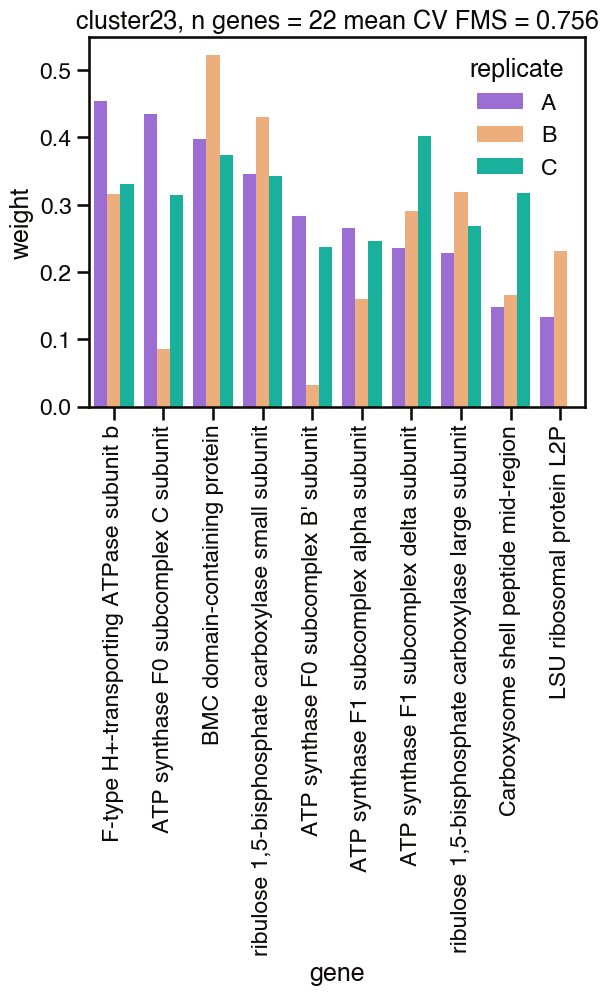

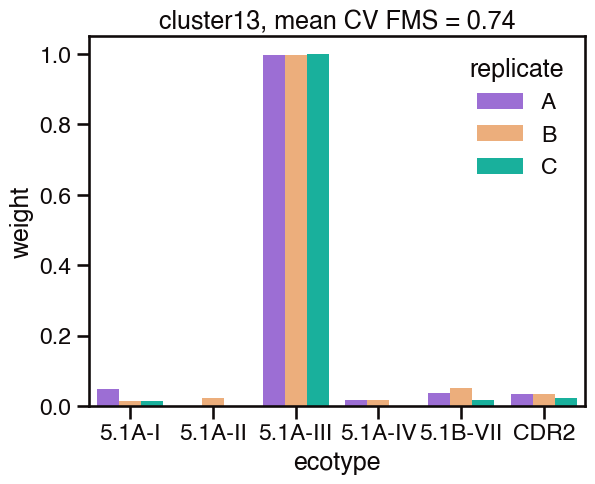

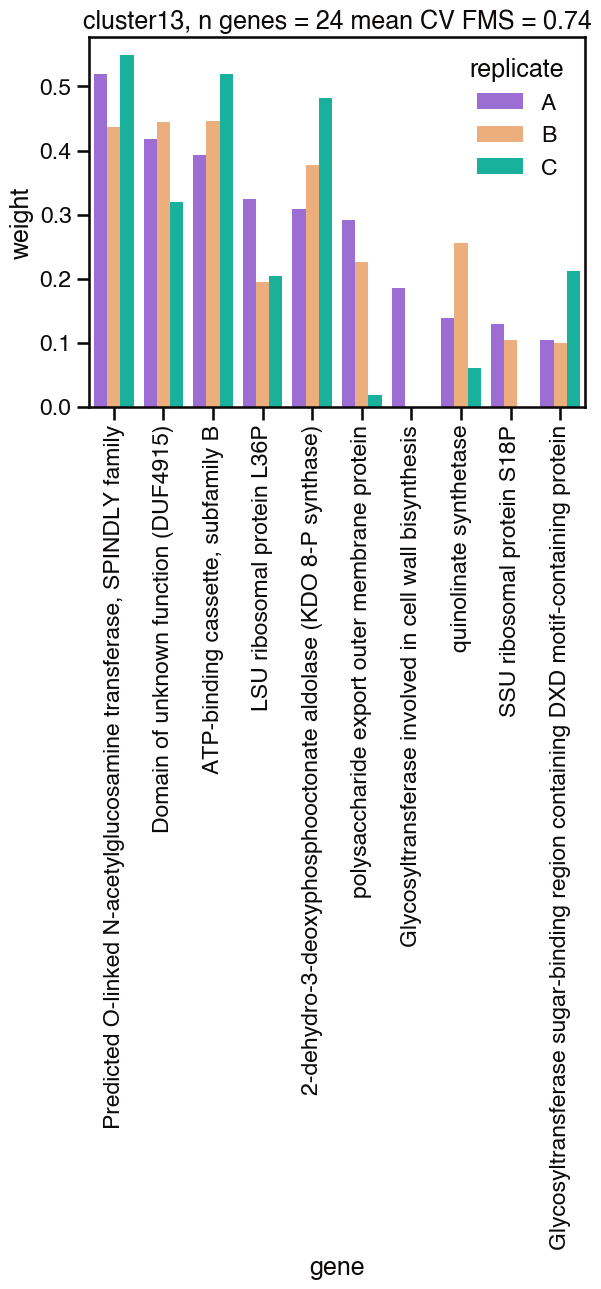

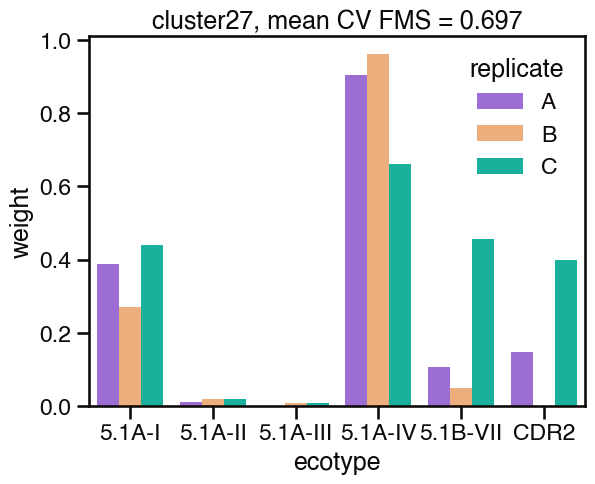

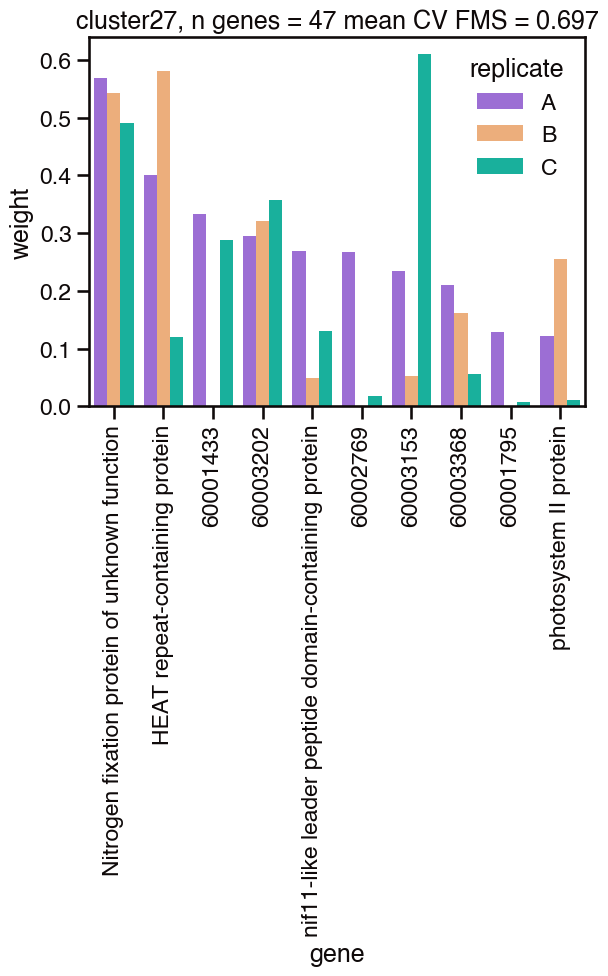

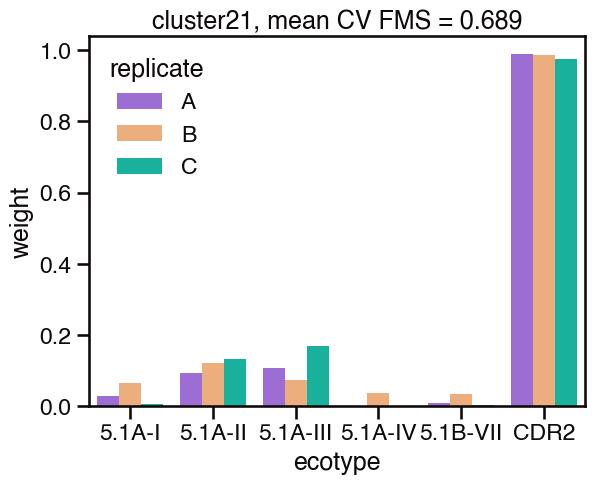

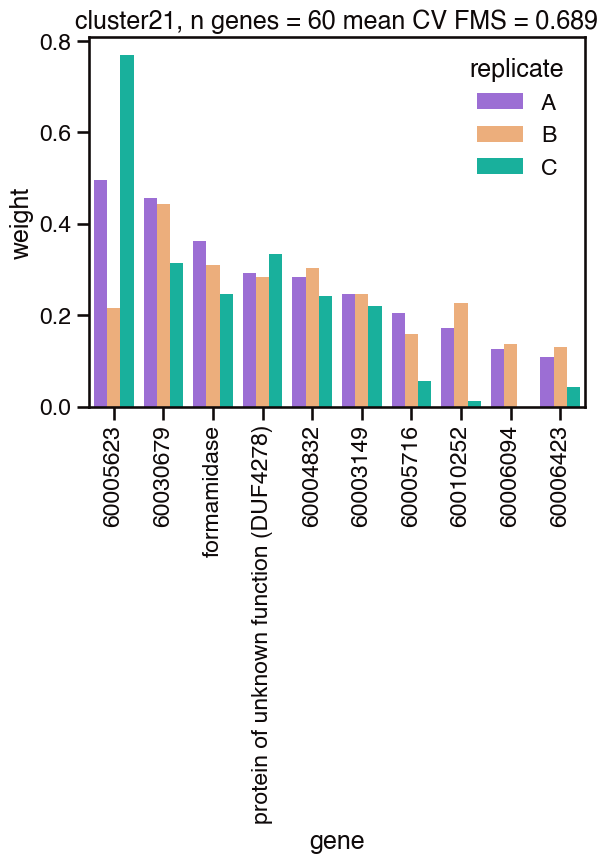

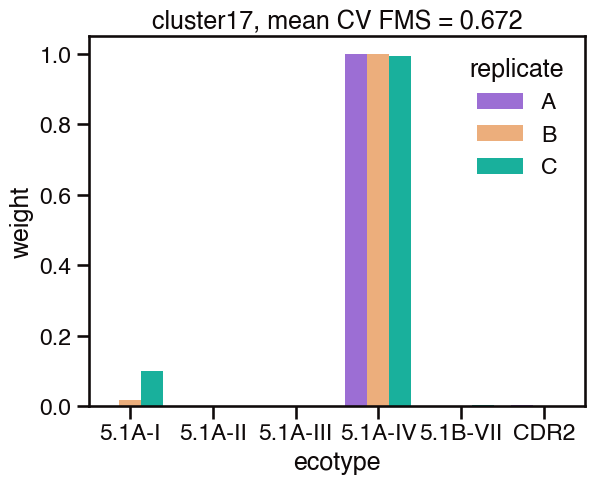

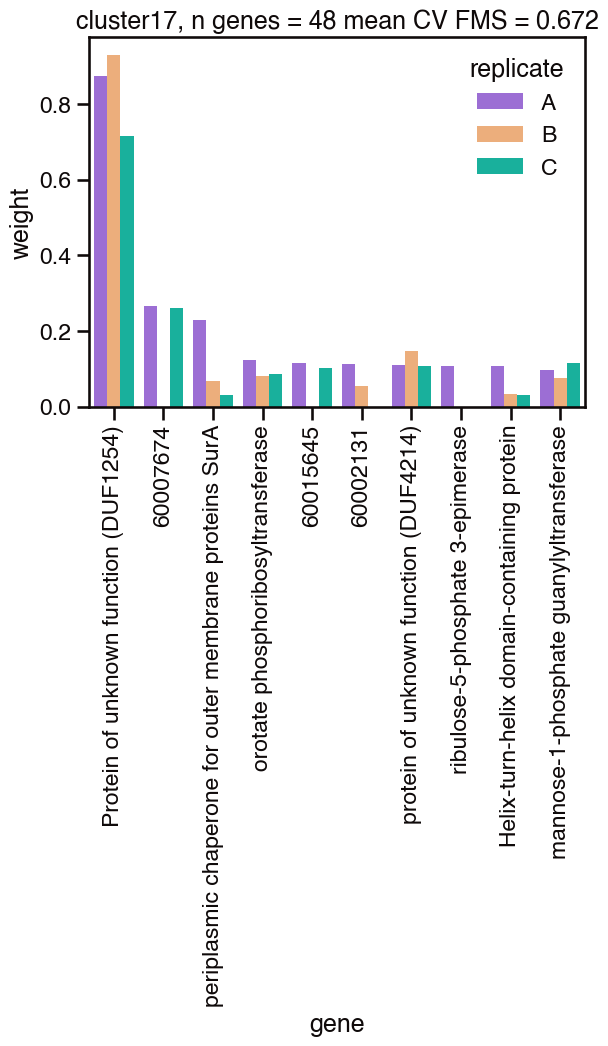

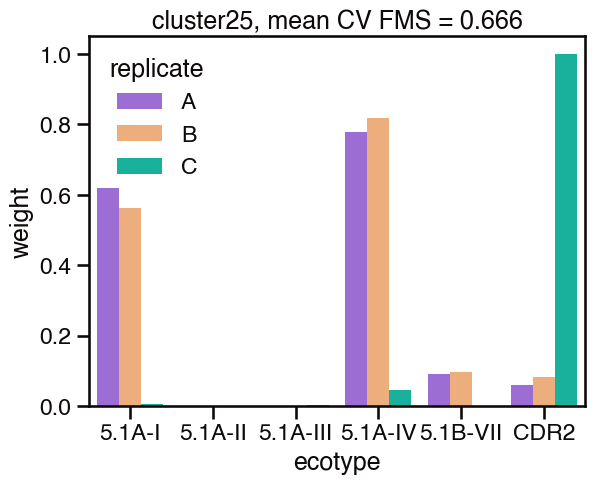

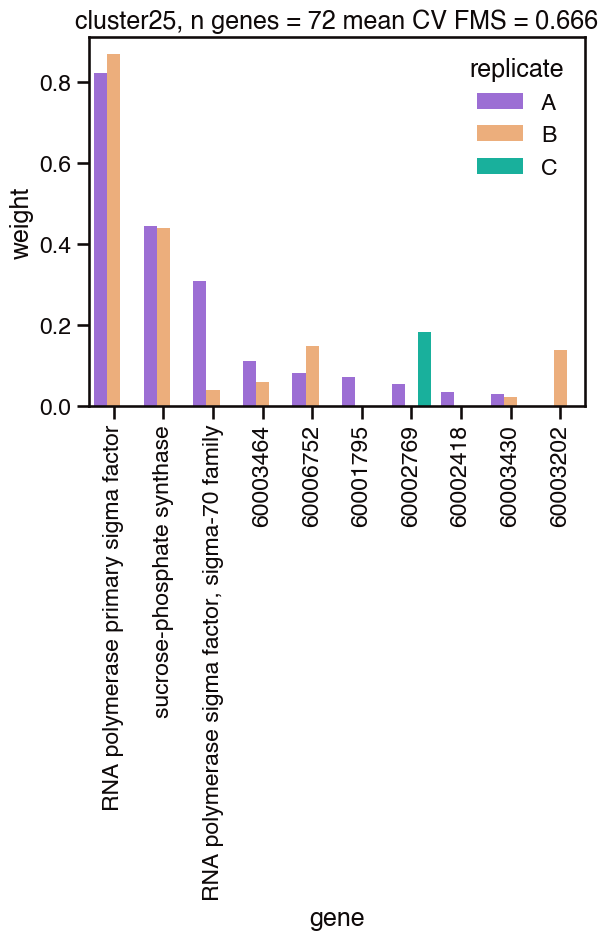

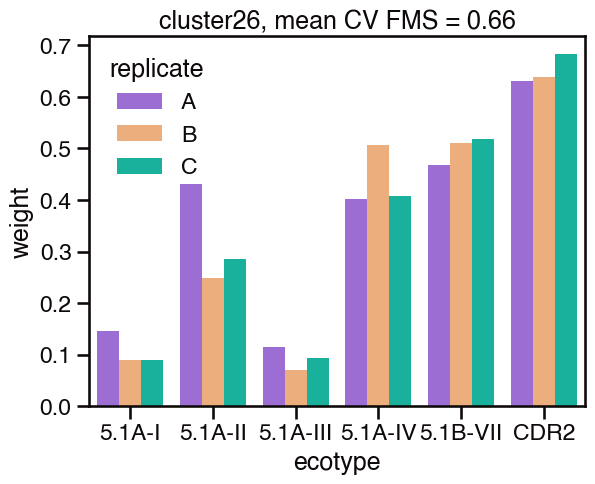

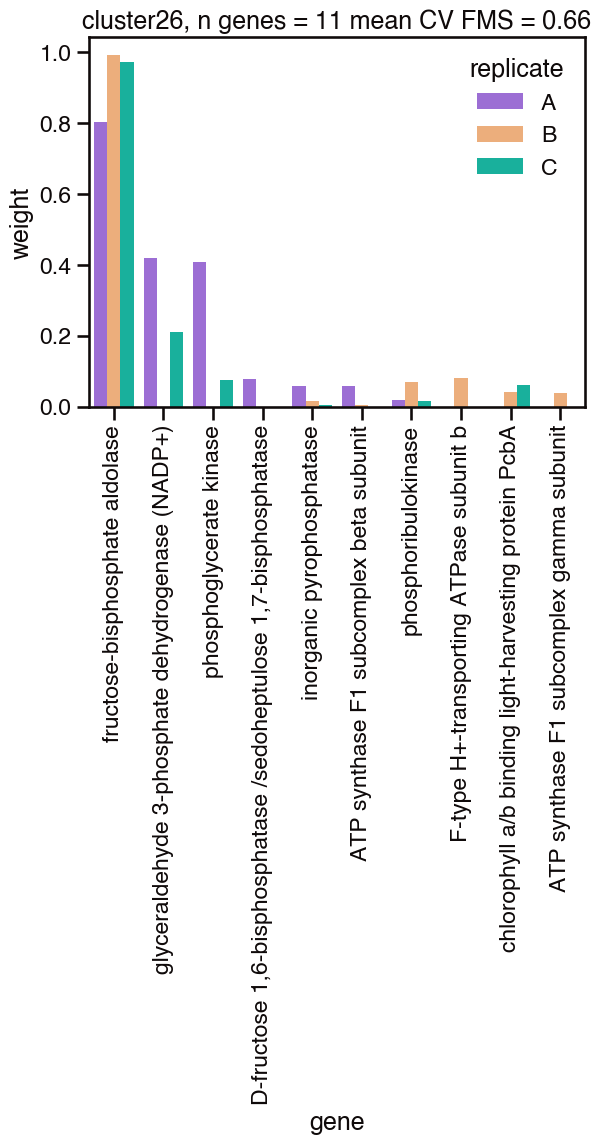

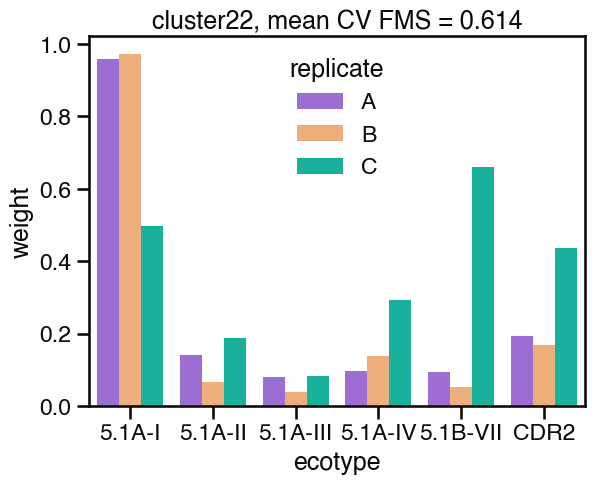

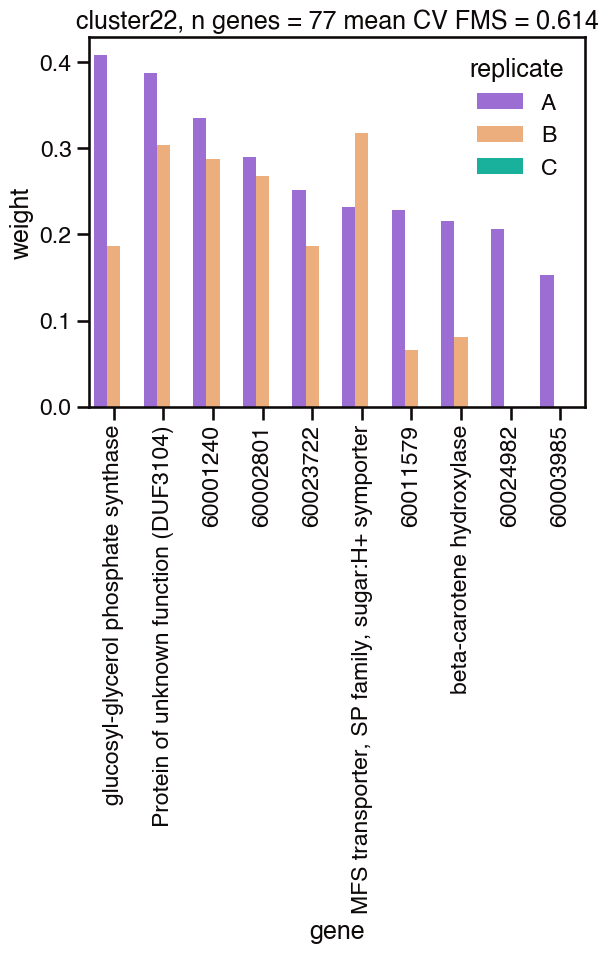

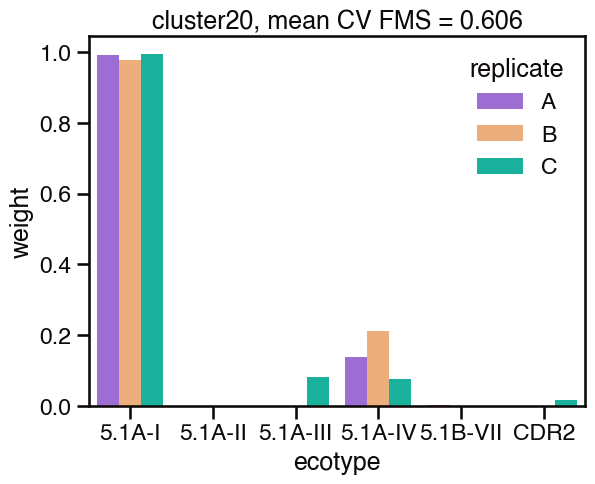

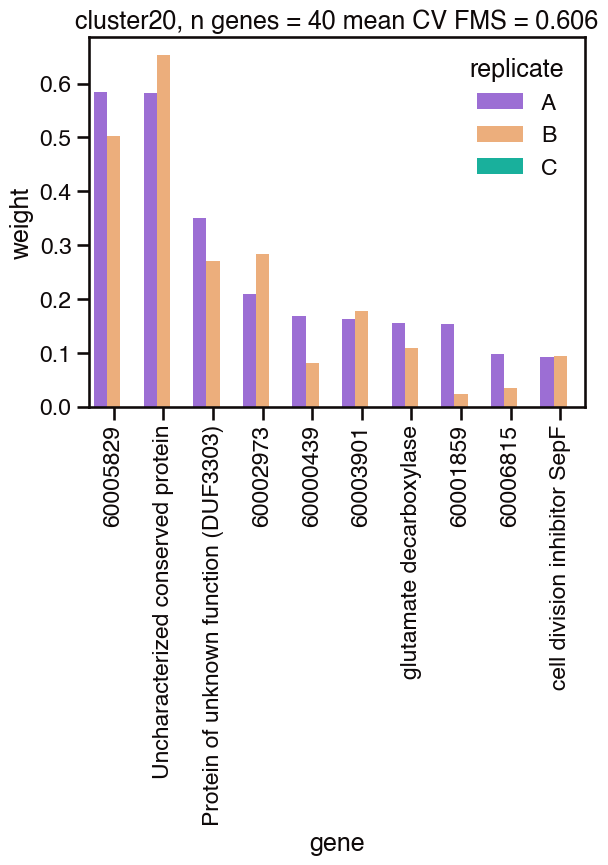

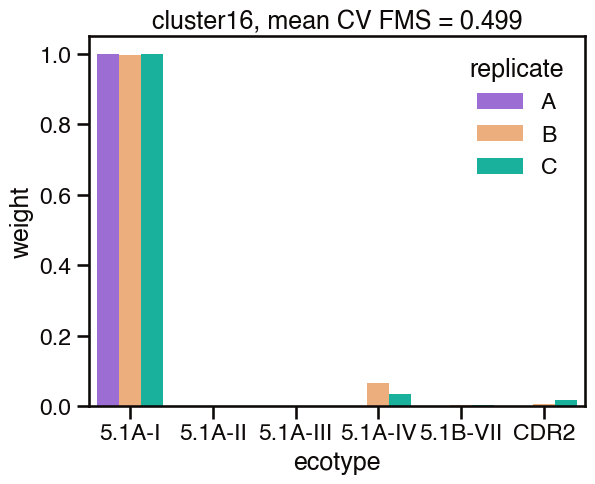

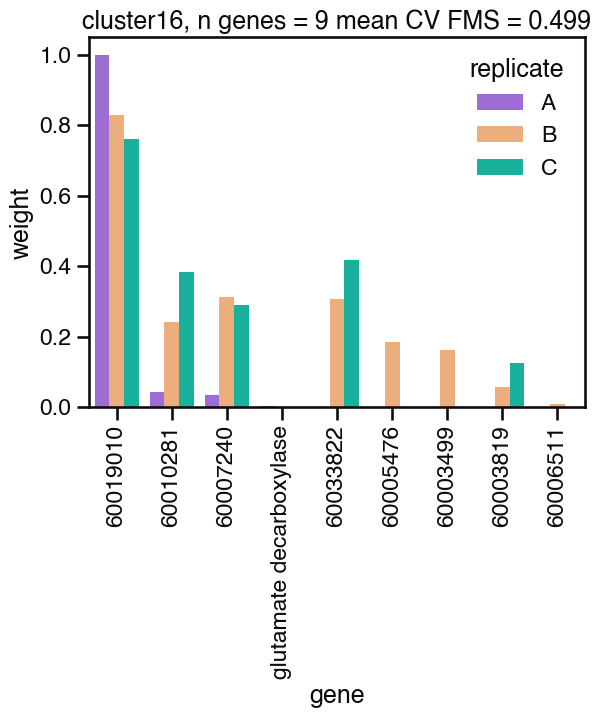

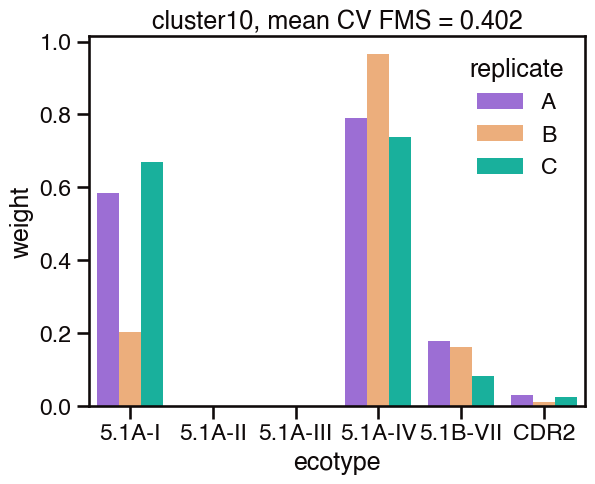

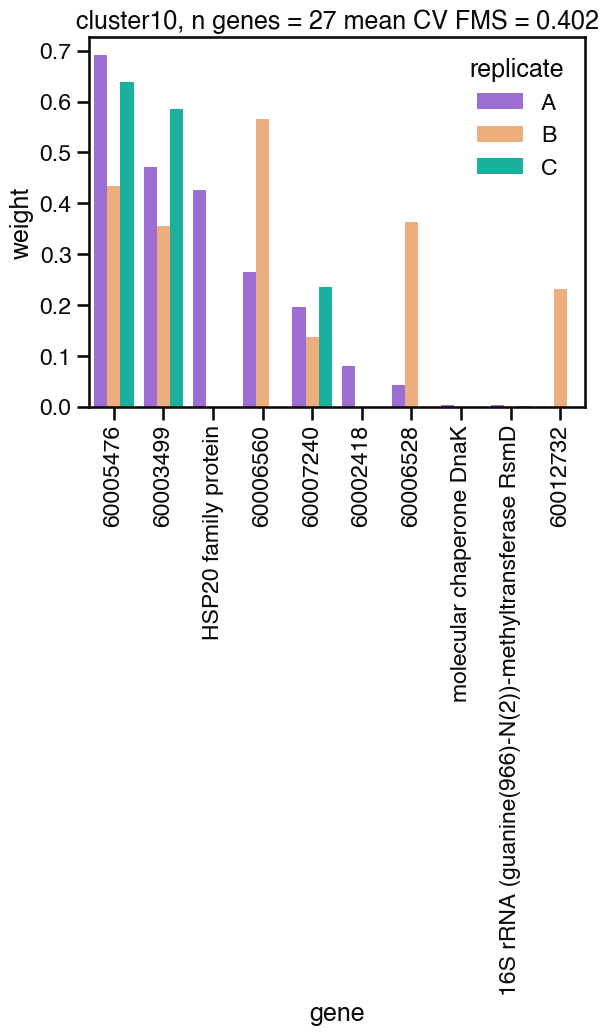

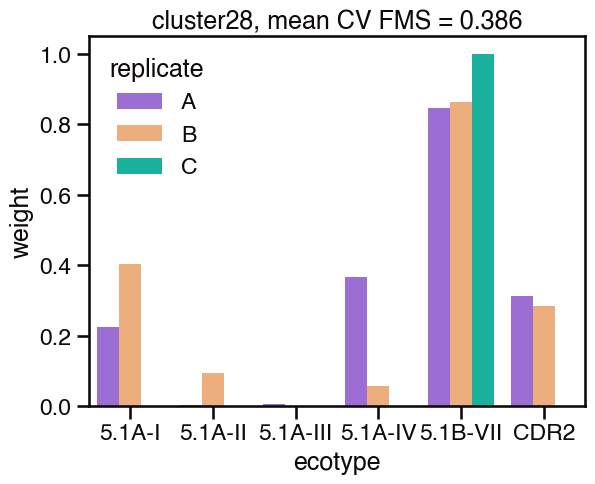

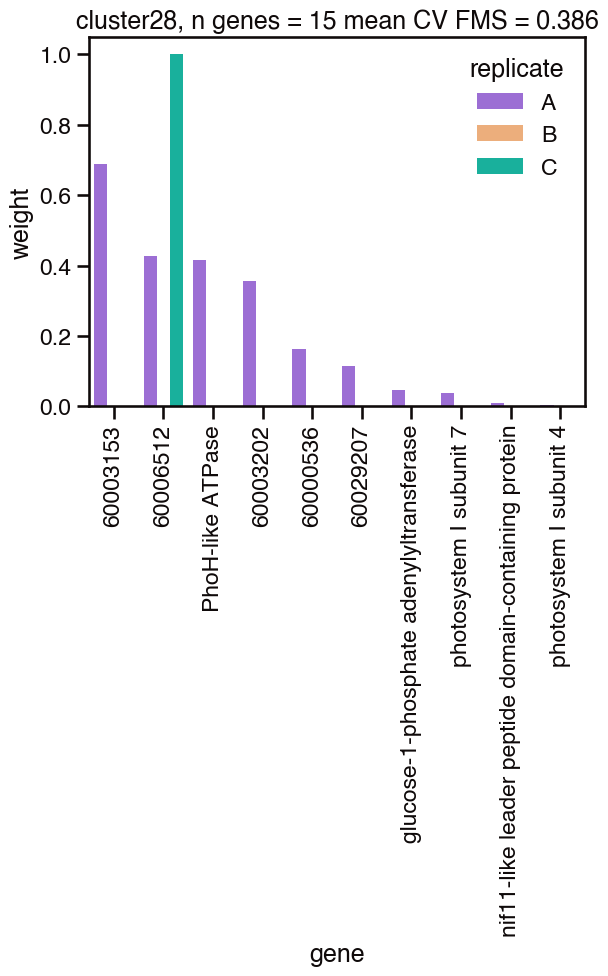

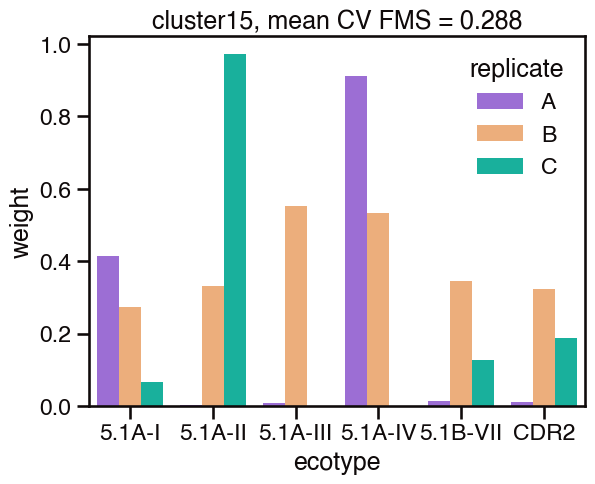

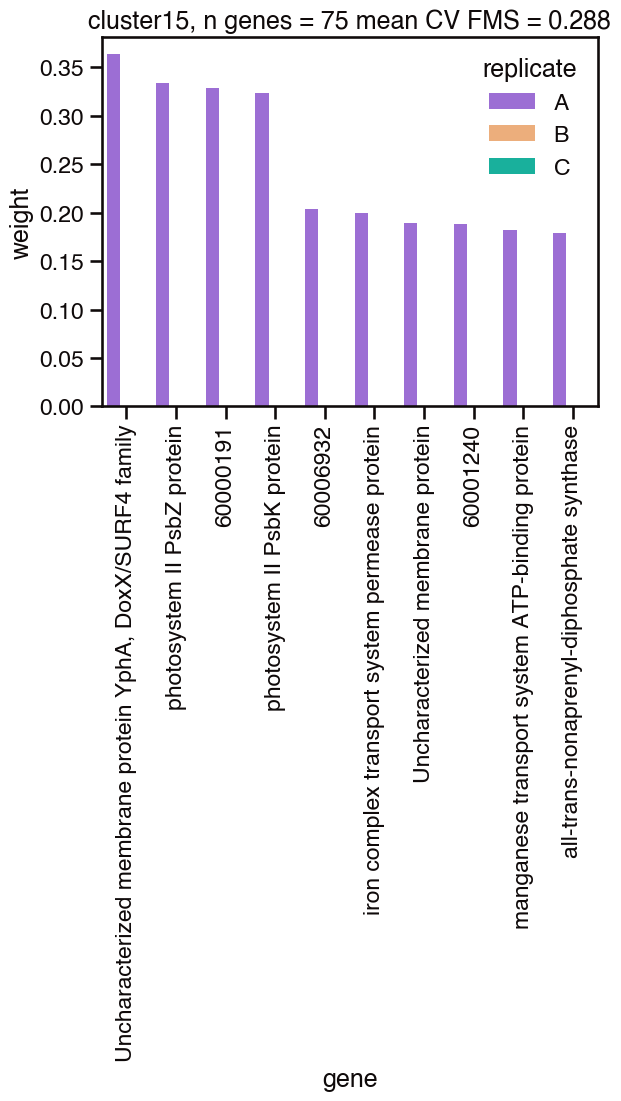

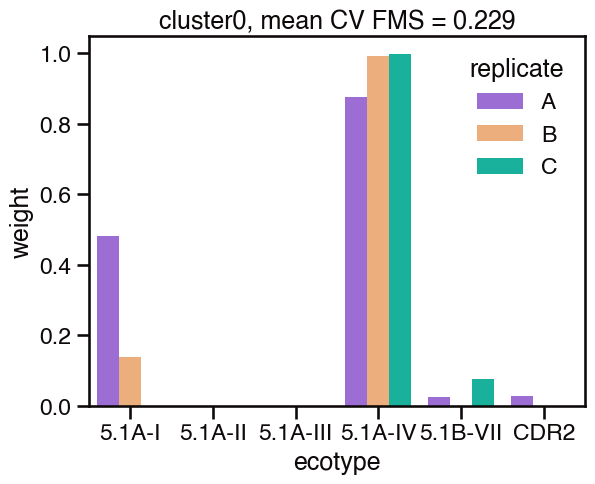

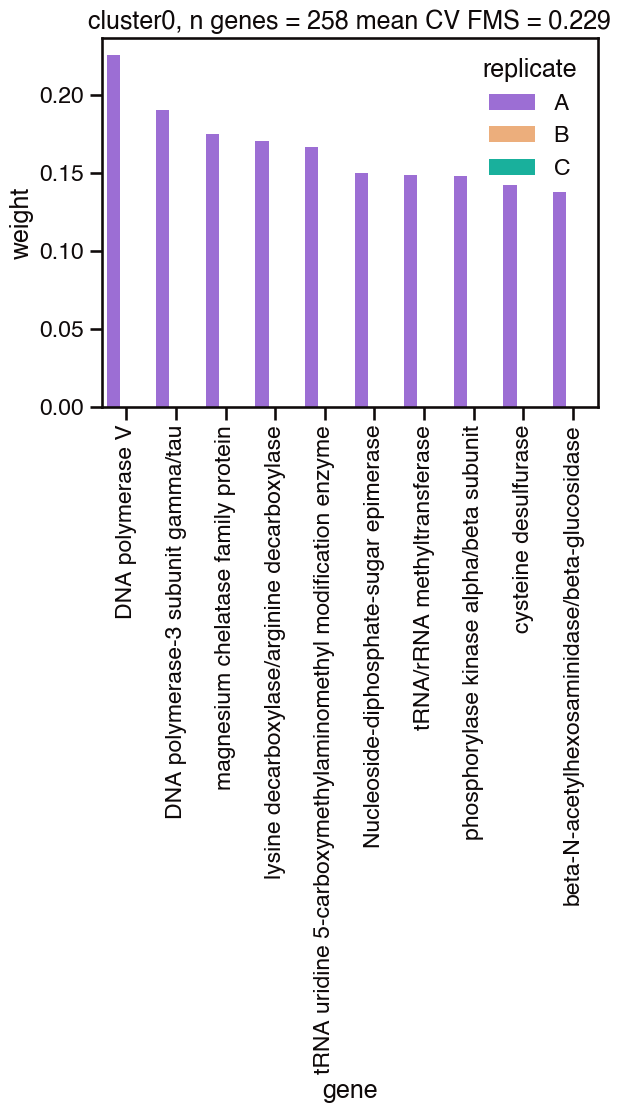

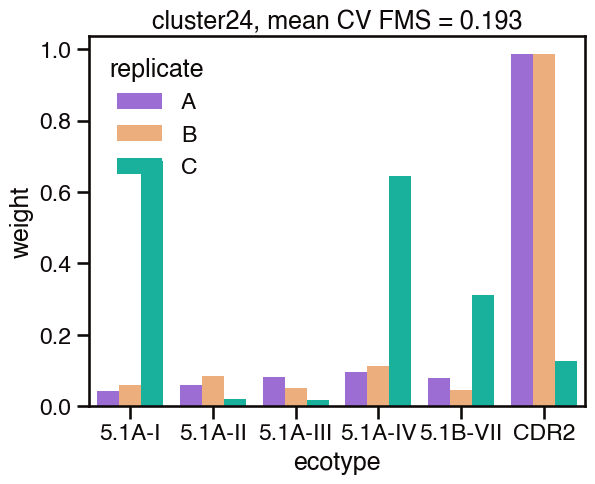

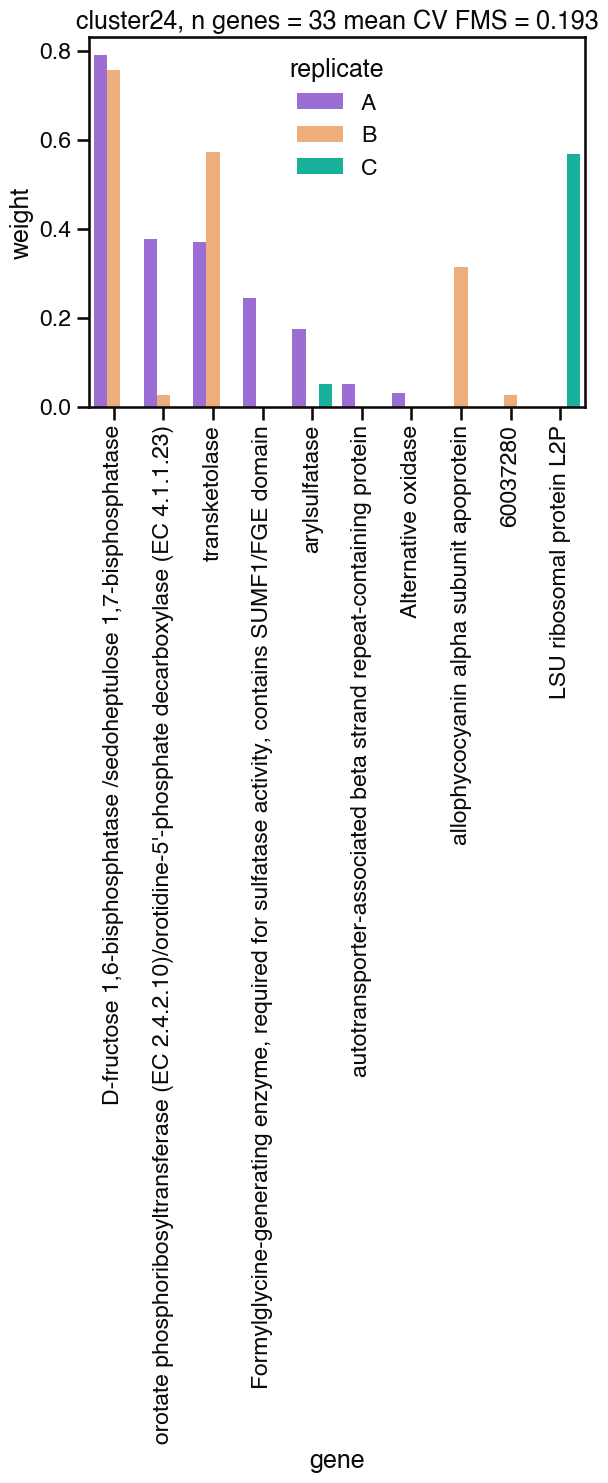

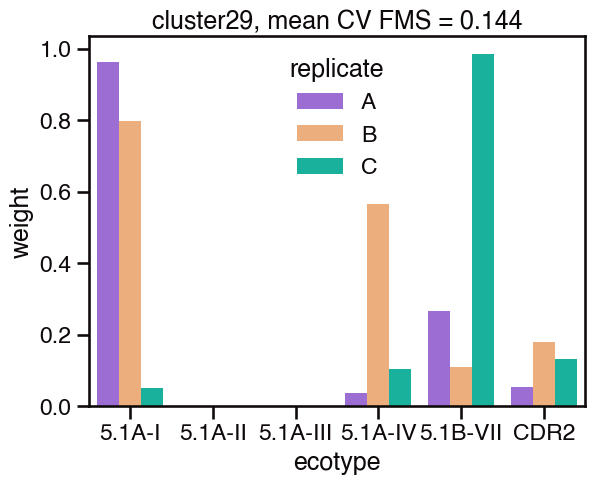

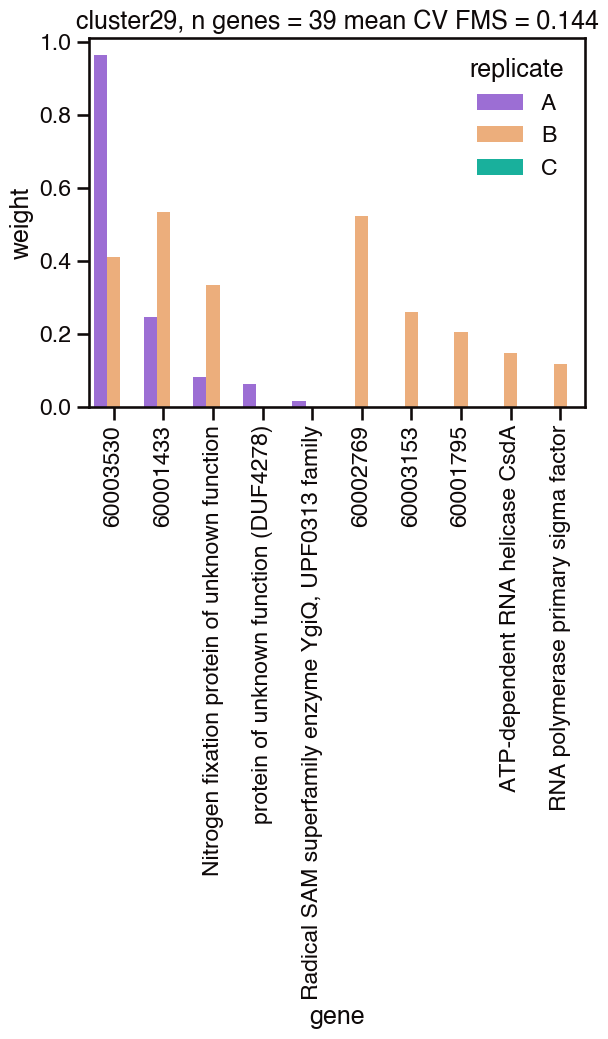

In [61]:
# plot clade weights

bootstrap = 0

for i, row in summary_component_df.iterrows():
    r = row['reference_component']
    eco_weights_df = pd.DataFrame(
        zip(
            tensor_ds.clade.data, 
            aligned_cps[bootstrap]['A'].factors[1][:, r], 
            aligned_cps[bootstrap]['B'].factors[1][:, r], 
            aligned_cps[bootstrap]['C'].factors[1][:, r]
        ), 
        columns=['ecotype', 'A', 'B', 'C']
    ).melt(id_vars='ecotype', value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight')

    sns.barplot(x='ecotype', y='weight', hue='replicate', data=eco_weights_df);
    plt.title('cluster{}, mean CV FMS = {:.3}'.format(r, row['mean_fms']))
    plt.show()
#     plt.savefig('ecotype.png', bbox_inches='tight')


# Figure 2b
Sample weights vs latitude by cruise

In [ ]:
# # look at sample weights

# sample_weights_df = eco_weights_df = pd.DataFrame(
#     zip(tensor_ds.clade.data, cps['A'].factors[1][:, 0], cps['B'].factors[1][:, 0], cps['C'].factors[1][:, 0]), 
#     columns=['sample', 'A', 'B', 'C']
# ).melt(id_vars='ecotype', value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight')

# ).sort_values('weight', ascending=False)

# sample_weights_df = pd.merge(sample_weights_df, sample_df, 
#                              left_on='sample', right_on='sampleid').sort_values('year')

# cmap = [sns.color_palette()[i] for i in [0, 6]]
# sns.scatterplot(x='latitude', y='weight', style='year', hue='split', palette=cmap, data=sample_weights_df);


# genes figure
Weights by transcript by split

In [ ]:
# look at transcript weights

for r in range(rank):
    tx_weights_df = pd.DataFrame(
        zip(
            tensor_ds.ortholog.data, 
            tensor_ds.annotation.data, 
            aligned_cps[bootstrap]['A'].factors[0][:, r], 
            aligned_cps[bootstrap]['B'].factors[0][:, r], 
            aligned_cps[bootstrap]['C'].factors[0][:, r]
        ), 
        columns=['ortholog', 'annotation', 'A', 'B', 'C']
    )

    tx_weights_df = tx_weights_df[np.any(tx_weights_df[['A', 'B', 'C']].gt(0), axis=1)].sort_values(
        ['A', 'B', 'C'], ascending=False
    )
    
    # replace hypotheticals with ortholog ids
    tx_weights_df['gene'] = [row['ortholog'] if row['annotation'] == 'hypothetical protein' \
                             else row['annotation'] for _, row in tx_weights_df.iterrows()]
        
    # just take the top ten
    n_genes = len(tx_weights_df)
    tx_weights_df = tx_weights_df.head(10)
    
    tx_weights_df = tx_weights_df.melt(
        id_vars=['gene', 'ortholog', 'annotation'], 
        value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight'
    )

#     sns.barplot(x='annotation', y='weight', hue='replicate', data=tx_weights_df[tx_weights_df.weight.gt(.2)])
    sns.barplot(x='gene', y='weight', hue='replicate', data=tx_weights_df)
    plt.xticks(rotation=90);
    plt.title('cluster{}, n genes = {} mean CV FMS = {:.3}'.format(r, n_genes, row['mean_fms']))
    plt.show()
#     plt.savefig('orthologs.png', bbox_inches='tight')


In [ ]:
# look at sample weights of specific cluster

cluster = 7
sample_weights_df = pd.DataFrame(
    zip(
        samplenames['common'], 
        aligned_cps['A'].factors[2][:, cluster], 
        aligned_cps['B'].factors[2][:, cluster], 
        aligned_cps['C'].factors[2][:, cluster]
    ), 
    columns=['samplename', 'A', 'B', 'C']
)

# select only samples with some weight
sample_weights_df = sample_weights_df[np.any(sample_weights_df[['A', 'B', 'C']].gt(0), axis=1)].sort_values(
    ['A', 'B', 'C'], ascending=False
)

# # melt df
# sample_weights_df = sample_weights_df.melt(
#     id_vars='samplename', 
#     value_vars=['A', 'B', 'C'], var_name='replicate', value_name='weight'
# )

# sns.barplot(x='samplename', y='weight', hue='replicate', data=sample_weights_df)
# plt.xticks(rotation=90);
# plt.title('cluster{}'.format(cluster))
# plt.show()

sample_weights_df


# Figure 2d
Ortholog residuals by latitude and clade

In [ ]:
# find indices of genes of interest

goi_indices = np.where(indices_syn['ortholog'].isin(tx_weights_df.index))
tx_weights_df['tensorindex'] = tx_weights_df.index.map(dict(zip(indices_syn['ortholog'][goi_indices], 
                                                                goi_indices[0])))

tx_weights_df


In [ ]:
# get residuals of interest

resid_df = pd.DataFrame()
gene_idx = [1104, 1270, 22, 1936]
for gene in gene_idx:
    df = pd.DataFrame(tensor_syn[gene].T, index=indices_syn['sample'], columns=indices_syn['clade'])
    df['latitude'] = df.index.map(sample_df.set_index('sampleid')['latitude'])
    df['ortholog'] = tx_weights_df.set_index('tensorindex').loc[gene, 'ortholog']
    if len(resid_df) == 0:
        resid_df = df
    else:
        resid_df = pd.concat([resid_df, df], axis=0)

resid_df = resid_df.reset_index()
resid_df = resid_df.rename(columns={'index': 'sample'})
resid_df = resid_df.melt(id_vars=['sample', 'latitude', 'ortholog'], 
                         value_vars=['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-I', '5.1B-VII', 'CRD2'], 
                         var_name='ecotype', 
                         value_name='residual')

resid_eco_df = resid_df[resid_df.ecotype.isin(['5.1A-I', '5.1A-IV', '5.1B-VII', 'CRD2'])]

fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 8))
cmap = [sns.color_palette()[i] for i in [4, 1, 9, 7]]
for i, ortho in enumerate(['flavodoxin', 'isiA', 'FBP aldolase', 'hypothetical 1']):
    legend = not i
    sns.scatterplot(
        x='latitude', 
        y='residual', 
        hue='ecotype', 
        style='ecotype', 
        data=resid_eco_df[resid_eco_df['ortholog'] == ortho], 
        palette=cmap, 
        ax=axes[i], 
        legend=legend
    );
    axes[i].set_title(ortho);
fig.tight_layout()  
axes[0].legend(title='ecotype', loc='center left', bbox_to_anchor=[1.02, -1.3]);


# Full Figure 2

In [ ]:
# make composite figure

fig = plt.figure(figsize=(12, 10))

grid = plt.GridSpec(36, 2, wspace=.25, hspace=30)

# plot Figure 1a
ax_a = plt.subplot(grid[0:9, 0])
ax_a.annotate('a', xy=(-0.15, 1.15), xycoords='axes fraction', va='center', ha='left', weight='bold', 
             fontsize=15, annotation_clip=False)
# plot ecotype weights
cmap = [sns.color_palette()[i] for i in [0, 6]]
sns.barplot(
    x='ecotype', 
    y='weight', 
    hue='split', 
    palette=cmap, 
    data=eco_weights_df, 
    ax=ax_a
)


# plot Figure 1b
ax_b = plt.subplot(grid[10:19, 0])
ax_b.annotate('b', xy=(-0.15, 1.15), xycoords='axes fraction', va='center', ha='left', weight='bold', 
             fontsize=15, annotation_clip=False)
# plot sample weights
cmap = [sns.color_palette()[i] for i in [0, 6]]
sns.scatterplot(
    x='latitude', 
    y='weight', 
    style='year', 
    hue='split', 
    palette=cmap, 
    data=sample_weights_df, 
    ax=ax_b
)
ax_b.legend(loc='upper left')


# plot Figure 1c
ax_c = plt.subplot(grid[20:29, 0])
ax_c.annotate('c', xy=(-0.15, 1.15), xycoords='axes fraction', va='center', ha='left', weight='bold', 
             fontsize=15, annotation_clip=False)
# plot nonzero ortholog weights
cmap = [sns.color_palette()[i] for i in [0, 6]]
sns.barplot(
    x='ortholog', 
    y='weight', 
    hue='split', 
    palette=cmap, 
    data=tx_weights, 
    ax=ax_c
)
plt.xticks(rotation=90);


# # plot Figure 1d
# fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 8), ax=grid[0:3,1])
# # ax_d.annotate('d', xy=(-0.2, 1.05), xycoords='axes fraction', va='center', ha='left', weight='bold', 
# #              fontsize=15, annotation_clip=False)# get data in shape

cmap = [sns.color_palette()[i] for i in [4, 1, 9, 7]]
for i, ortho in enumerate(['flavodoxin', 'isiA', 'FBP aldolase', 'hypothetical 1']):
    legend = (i == 2)
    ax_d = plt.subplot(grid[i*8+i:i*8+i+8, 1])
    if not i:
        ax_d.annotate('d', xy=(-0.15, 1.2), xycoords='axes fraction', va='center', ha='left', weight='bold', 
                     fontsize=15, annotation_clip=False)
    sns.scatterplot(
        x='latitude', 
        y='residual', 
        hue='ecotype', 
        style='ecotype', 
        data=resid_eco_df[resid_eco_df['ortholog'] == ortho], 
        palette=cmap, 
        ax=ax_d, 
        legend=legend, 
    );
    ax_d.set_title(ortho);
    if legend:
        ax_d.legend(title='ecotype', loc='center left', bbox_to_anchor=[1, .7]);
    if (i != 3):
        ax_d.set(xlabel=None)
        ax_d.set(xticklabels=[])

fig.savefig('../figures/robust_iron_cluster.png', bbox_inches='tight')


# Mystery Gene

In [ ]:
# Look up the highly weighted hypothetical protein

ortholog_df[(ortholog_df['GenomeName'].isin(['BL107', 'CC9902'])) & (ortholog_df['OrthologID'] == 60002623)]


# 60002623 is a putative histidine phosphotase in clade IV Synechococcus

#### nt sequence:
>CC9902_2606886696

>ATGGGTGCTGAGAGCAAAGCGCACCAATTCTTCGATGAAGCTAAACACGA
ATCAACCTACAGCTTGATCCAGGAACTACAGAAAGGGGGAAAGATCATAT
ATATGAGACATGCAGCAACAAAGACTGACTGGGCTGATCAAGCATCTCTT
GAATTATCACTGGATGATTGCTCAACACAAAGAGAGCTCAGCGCGGCGGG
GAAATTACAAGCAATGAAAATCGGCGATTCACTCAGAAATCATGATGTAC
CGATAGGTCGTGTCATATCAAGCGAATATTGCCGAGCGATTGATACGGCA
CAACTTTCATTCGGAGAACATGAAACAAACAAAGCACTTAATTTTCTTCC
ATGCGAGGTATGTACAGAAAGTGATAACGAGATCTATCGACAGAGACTTT
TGCCCCTACTTTCCCAATCCATCGATCAAAAACAAAATCTGGTTTTAGTC
GGTCATGATGACCCATTTGAAGCCATTACGGGGATCTATCCAGAGCCTAT
GGGCATTATCTTTATTATCGAACCAAAAGAGAAGCAGACTTTCAACATAC
TGGGATCAATTCATCCAGAAGACTTGATCAAGTTTAAACCCAACAGGAGA
GATGAAAAATGA

#### aa sequence: 
> VIRT-34503:5'3' Frame 1, start_pos=0

>MGAESKAHQFFDEAKHESTYSLIQELQKGGKIIYMRHAATKTDWADQASL
ELSLDDCSTQRELSAAGKLQAMKIGDSLRNHDVPIGRVISSEYCRAIDTA
QLSFGEHETNKALNFLPCEVCTESDNEIYRQRLLPLLSQSIDQKQNLVLV
GHDDPFEAITGIYPEPMGIIFIIEPKEKQTFNILGSIHPEDLIKFKPNRR
DEK-

- https://portlandpress.com/biochemj/article/409/2/333/43457/The-histidine-phosphatase-superfamily-structure
- https://onlinelibrary.wiley.com/doi/full/10.1046/j.1365-2958.1998.00703.x


# Iron stress related genes

- Flavodoxin (https://www.microbiologyresearch.org/content/journal/micro/10.1099/00221287-138-8-1613)
- FBP aldolase (https://www.koreascience.or.kr/article/JAKO201106737198399.pdf)
- PcbA (https://www.nature.com/articles/35098153)
- 60002623 ???